In [2]:
# std
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import re
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

# img viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# img proc
import cv2
from skimage import color, io

# ml
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# torch
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader

# KNN, RandomForest, DecisionTree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import time

In [3]:
# mount drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

In [4]:
class PlantDataset(Dataset):
    """Load images as needed. Directory must be placed as: datadir/split/category/*.png"""
    def __init__(self,
                 datadir='/content/drive/MyDrive/Tomato Leaf Disease Classification/final_dataset',
                 split='train',
                 fmt='np'):
        # store image list from disk
        self.im_paths = sorted(glob.glob(os.path.join(datadir, split, '**/*.png')))
        # store the labels and create lookup for easy retrieval
        self.lbl_list = list(map(lambda lbl: lbl.split(os.path.sep)[-2].lower(), self.im_paths))
        self.lbl_cat_lkp = {e: i for i, e in enumerate(sorted(list(set(self.lbl_list))))}
        self.cat_lbl_lkp = {i: e for e, i in self.lbl_cat_lkp.items()}
        self.cat = np.array([self.lbl_cat_lkp[e] for e in self.lbl_list])
        self.fmt=fmt
        self.split=split

    def get_impath(self, idx): return self.im_paths[idx]

    def __getitem__(self, idx):
        """Return processed image from file list"""
        if self.fmt=='torch':
            im_path = self.im_paths[idx]
            tim = read_image(im_path, ImageReadMode.RGB)
            return tim/255, self.cat[idx]
        elif self.fmt=='np':
            im_path = self.im_paths[idx]
            npim = plt.imread(im_path)[..., :3] # remove alpha channel
            return npim, self.cat[idx]

    def __len__(self): return len(self.im_paths)

train_dset = PlantDataset()
print(f'>> Images on {train_dset.split}: {len(train_dset):,}')
print(pd.Series(train_dset.lbl_list).value_counts())

val_dset = PlantDataset(split='validation')
print(f'\n>> Images on {val_dset.split}: {len(val_dset):,}')
print(pd.Series(val_dset.lbl_list).value_counts())

test_dset = PlantDataset(split='test')
print(f'\n>> Images on {test_dset.split}: {len(test_dset):,}')
print(pd.Series(test_dset.lbl_list).value_counts())

print(f'\n>> Total images: {len(test_dset) + len(val_dset) + len(train_dset):,}')

>> Images on train: 14,523
tomato_yellow_leaf_curl_virus           4285
bacterial_spot                          1701
late_blight                             1527
septoria_leaf_spot                      1416
spider_mites_two-spotted_spider_mite    1340
healthy                                 1272
target_spot                             1123
early_blight                             800
leaf_mold                                761
tomato_mosaic_virus                      298
dtype: int64

>> Images on validation: 1,812
tomato_yellow_leaf_curl_virus           535
bacterial_spot                          212
late_blight                             190
septoria_leaf_spot                      177
spider_mites_two-spotted_spider_mite    167
healthy                                 159
target_spot                             140
early_blight                            100
leaf_mold                                95
tomato_mosaic_virus                      37
dtype: int64

>> Images on test: 1,824

In [ ]:
train_dset.lbl_cat_lkp

{'bacterial_spot': 0,
 'early_blight': 1,
 'healthy': 2,
 'late_blight': 3,
 'leaf_mold': 4,
 'septoria_leaf_spot': 5,
 'spider_mites_two-spotted_spider_mite': 6,
 'target_spot': 7,
 'tomato_mosaic_virus': 8,
 'tomato_yellow_leaf_curl_virus': 9}

In [ ]:
val_dset.lbl_cat_lkp

{'bacterial_spot': 0,
 'early_blight': 1,
 'healthy': 2,
 'late_blight': 3,
 'leaf_mold': 4,
 'septoria_leaf_spot': 5,
 'spider_mites_two-spotted_spider_mite': 6,
 'target_spot': 7,
 'tomato_mosaic_virus': 8,
 'tomato_yellow_leaf_curl_virus': 9}

In [ ]:
test_dset.lbl_cat_lkp

{'bacterial_spot': 0,
 'early_blight': 1,
 'healthy': 2,
 'late_blight': 3,
 'leaf_mold': 4,
 'septoria_leaf_spot': 5,
 'spider_mites_two-spotted_spider_mite': 6,
 'target_spot': 7,
 'tomato_mosaic_virus': 8,
 'tomato_yellow_leaf_curl_virus': 9}

## Dim Reduction

### PCA

In [5]:
def displayPca(x_train, num_components = 100, display_pca = True):

  pca = PCA(n_components=num_components)
  X_train_pca = pca.fit_transform(x_train)

  if display_pca == False:
    return pca, X_train_pca

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

  # variance ratio % per PC
  sns.lineplot(x=np.arange(100), y=np.cumsum(pca.explained_variance_ratio_), ax=ax[0])
  ax[0].set_title(f'Pct Variance Explained for {nc} PCs: {pca.explained_variance_ratio_.sum():.0%}')

  # scatter of 2 PCs
  scatter = ax[1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train, alpha=0.5)
  legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")
  ax[1].add_artist(legend1)
  ax[1].set_title('Scatter of First 2 PCs')

  plt.show()

  return pca, X_train_pca

### TSNE

In [ ]:
def displayTsne(x_train):
  tsne = TSNE(n_components=2)
  X_tsne = tsne.fit_transform(x_train)
  fig, ax = plt.subplots()
  scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y_train, alpha=0.5)
  legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
  ax.set_title('First 2 components of t-SNE')
  plt.show()

## Classifiers

In [6]:
def plot_train_val_loss(history_dict):
  df = pd.DataFrame(history_dict)
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
  ax[0].plot(history_dict['loss'], 'b-o')
  ax[0].plot(history_dict['val_loss'], 'r-o')
  ax[0].legend(['loss', 'val_loss'])
  ax[0].set_title('Loss')

  ax[1].plot(history_dict['accuracy'], 'b-o')
  ax[1].plot(history_dict['val_accuracy'], 'r-o')
  ax[1].legend(['accuracy', 'val_accuracy'])
  ax[1].set_title('Accuracy')
  plt.show()

### Logistic Regression

In [7]:
@ignore_warnings(category=ConvergenceWarning)
def performLogisticRegression(x_train, y_train, x_val, y_val):

  x_train_val = np.concatenate([x_train, x_val])
  y_train_val = np.concatenate([y_train, y_val])
  cv_split = PredefinedSplit(np.concatenate([np.full(x_train.shape[0], -1), np.zeros(x_val.shape[0])]))

  param_grid = [
    {
        'penalty': ['l2', None],
        'class_weight': [None, 'balanced'],
        'max_iter': [100, 250, 500]
    }
  ]

  logistic_grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid = param_grid,
    cv = cv_split
  )
  logistic_grid_search.fit(x_train_val, y_train_val)

  display(pd.DataFrame(logistic_grid_search.cv_results_).sort_values('rank_test_score').head())

  print("\n\n\n")

  best_estimator = logistic_grid_search.best_estimator_

  train_preds = best_estimator.predict(x_train)
  print(f'Train Accuracy: {accuracy_score(train_preds, y_train):.2%}')
  val_preds = best_estimator.predict(x_val)
  print(f'Validation Accuracy: {accuracy_score(val_preds, y_val):.2%}')

  return best_estimator

### FeatureNet

In [ ]:
class FeatureNet(keras.Model):
  def __init__(self, num_layers=3, name='features_model'):
    super().__init__(name=name)
    self.num_layers = num_layers
    self.dense1 = keras.layers.Dense(units=512, activation='relu', name='dense1')
    self.dropout1 = keras.layers.Dropout(.25)
    self.dense2 = keras.layers.Dense(units=256, activation='relu', name='dense2')
    self.dropout2 = keras.layers.Dropout(.2)
    self.out = None
    if num_layers == 2:
      self.out = keras.layers.Dense(units=10, activation='softmax', name='softmax')
    else:
      self.dense3 = keras.layers.Dense(units=64, activation='relu', name='dense3')
      self.dropout3 = keras.layers.Dropout(.2)
      self.out = keras.layers.Dense(units=10, activation='softmax', name='softmax')

  def call(self, inputs, training=False):
    x = self.dense1(inputs)
    x = self.dropout1(x)
    x = self.dense2(x)
    x = self.dropout2(x)
    if self.num_layers == 3:
      x = self.dense3(x)
      x = self.dropout3(x)
    return self.out(x)

def performFeatureNet(x_train, y_train, x_val, y_val, num_layers=3):
  model = FeatureNet(num_layers = num_layers)
  es_callback = EarlyStopping(monitor='val_loss', patience=3)
  model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=['accuracy']
  )

  start_time = time.time()
  history = model.fit(
      x_train, y_train,
      batch_size=64,
      epochs=20,
      validation_data=(x_val, y_val),
      callbacks=[es_callback]
  )
  print(f'\n\nTime taken to fit the model: {time.time() - start_time}s')

  plot_train_val_loss(history.history)

  return model

### Random Forest


In [19]:
def performRandomForest(x_train, y_train, x_val, y_val):

  x_train_val = np.concatenate([x_train, x_val])
  y_train_val = np.concatenate([y_train, y_val])
  cv_split = PredefinedSplit(np.concatenate([np.full(x_train.shape[0], -1), np.zeros(x_val.shape[0])]))

  param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 6, 7]
  }

  randomforest_grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid = param_grid,
    cv = cv_split
  )
  randomforest_grid_search.fit(x_train_val, y_train_val)

  display(pd.DataFrame(randomforest_grid_search.cv_results_).sort_values('rank_test_score').head())

  print("\n\n\n")

  best_estimator = randomforest_grid_search.best_estimator_

  train_preds = best_estimator.predict(x_train)
  print(f'Train Accuracy: {accuracy_score(train_preds, y_train):.2%}')
  val_preds = best_estimator.predict(x_val)
  print(f'Validation Accuracy: {accuracy_score(val_preds, y_val):.2%}')

  return best_estimator

## Train + Validation Peformance of Various Feature Vectors

In [8]:
def read_features_from_files(file_list):
  feats = [pd.read_csv(f).values for f in file_list]
  return np.concatenate(feats, axis=1).astype(np.float32)

In [9]:
Y_train = train_dset.cat
Y_val = val_dset.cat
Y_test = test_dset.cat

### RGB B100 vs LAB B100

#### Train + Validation Performance of RGB B100

In [9]:
X_rgb_b100_train = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_rgbhist_b100_r0-1_prob.csv'
])
print('Train:', X_rgb_b100_train.shape, Y_train.shape)

X_rgb_b100_val = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_rgbhist_b100_r0-1_prob.csv'
])
print('Validation:', X_rgb_b100_val.shape, Y_val.shape)

X_rgb_b100_test = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_rgbhist_b100_r0-1_prob.csv'
])
print('Test:', X_rgb_b100_test.shape, Y_test.shape)

Train: (14523, 300) (14523,)
Validation: (1812, 300) (1812,)
Test: (1824, 300) (1824,)


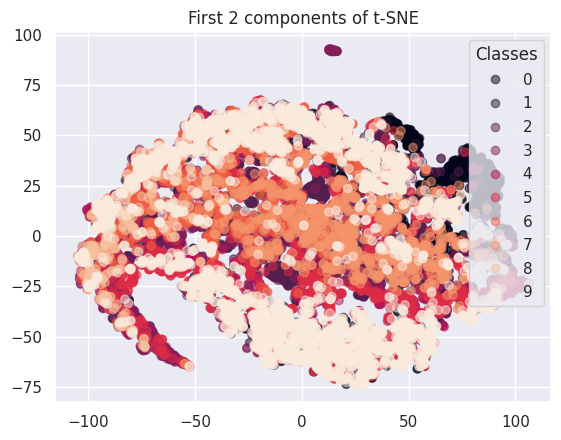

In [ ]:
displayTsne(X_rgb_b100_train)

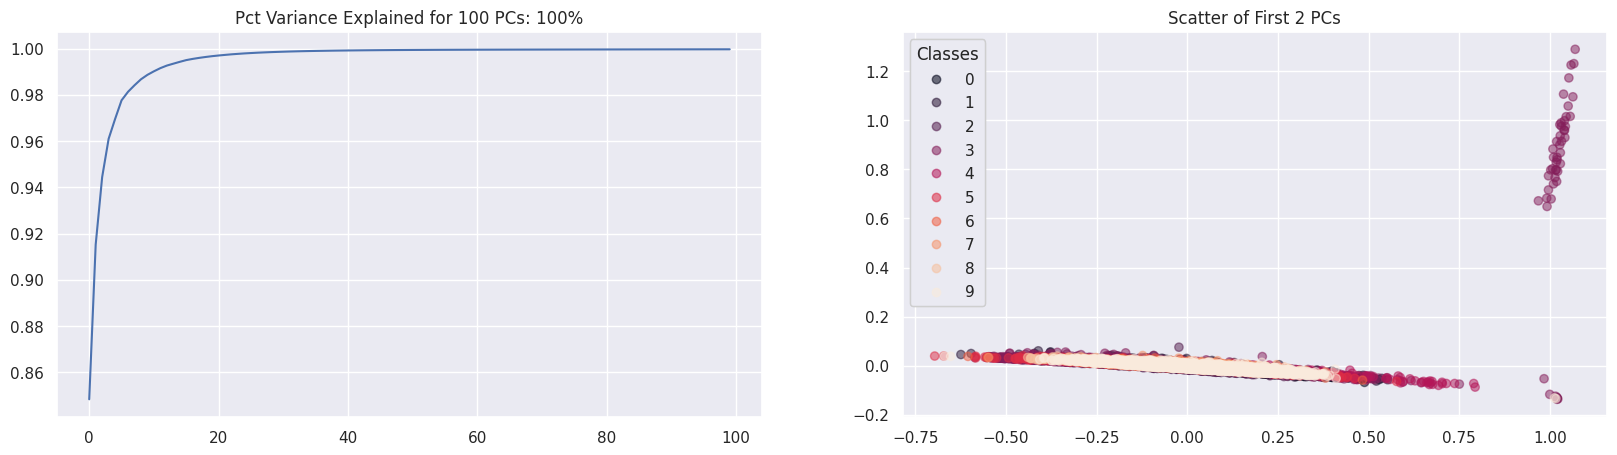

In [ ]:
rgb_b100_pca, X_rgb_b100_train_pca = displayPca(X_rgb_b100_train)
X_rgb_b100_val_pca = rgb_b100_pca.transform(X_rgb_b100_val)

In [10]:
logistic_model_rgb_b100 = performLogisticRegression(X_rgb_b100_train, Y_train, X_rgb_b100_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       22.742177           0.0         0.005166             0.0   
11      22.564534           0.0         0.017245             0.0   
3       11.428170           0.0         0.004550             0.0   
9       11.273188           0.0         0.004024             0.0   
1        4.016502           0.0         0.008796             0.0   

   param_class_weight param_max_iter param_penalty  \
5                None            500          None   
11           balanced            500          None   
3                None            250          None   
9            balanced            250          None   
1                None            100          None   

                                               params  split0_test_score  \
5   {'class_weight': None, 'max_iter': 500, 'penal...           0.672737   
11  {'class_weight': 'balanced', 'max_iter': 500, ...           0.663907   
3   {'class_weight': None, 'max_iter': 250, 'penal...           0.627483   
9   {'class_weight': 'balanced', 'max_iter': 250, ...           0.608720   
1   {'class_weight': None, 'max_iter': 100, 'penal...           0.541391   

    mean_test_score  std_test_score  rank_test_score  
5          0.672737             0.0                1  
11         0.663907             0.0                2  
3          0.627483             0.0                3  
9          0.608720             0.0                4  
1          0.541391             0.0                5





Train Accuracy: 67.76%
Validation Accuracy: 67.94%


Epoch 1/20
227/227 [==============================] - 3s 12ms/step - loss: 1.8015 - accuracy: 0.4003 - val_loss: 1.4887 - val_accuracy: 0.5017
Epoch 2/20
227/227 [==============================] - 3s 15ms/step - loss: 1.3622 - accuracy: 0.5444 - val_loss: 1.2278 - val_accuracy: 0.5789
Epoch 3/20
227/227 [==============================] - 2s 11ms/step - loss: 1.2013 - accuracy: 0.5920 - val_loss: 1.1128 - val_accuracy: 0.6159
Epoch 4/20
227/227 [==============================] - 2s 10ms/step - loss: 1.1120 - accuracy: 0.6252 - val_loss: 1.0221 - val_accuracy: 0.6617
Epoch 5/20
227/227 [==============================] - 2s 10ms/step - loss: 1.0486 - accuracy: 0.6473 - val_loss: 0.9531 - val_accuracy: 0.6766
Epoch 6/20
227/227 [==============================] - 2s 10ms/step - loss: 0.9994 - accuracy: 0.6624 - val_loss: 0.9185 - val_accuracy: 0.6932
Epoch 7/20
227/227 [==============================] - 3s 11ms/step - loss: 0.9577 - accuracy: 0.6780 - val_loss: 0.8699 - val_accuracy: 0.7064

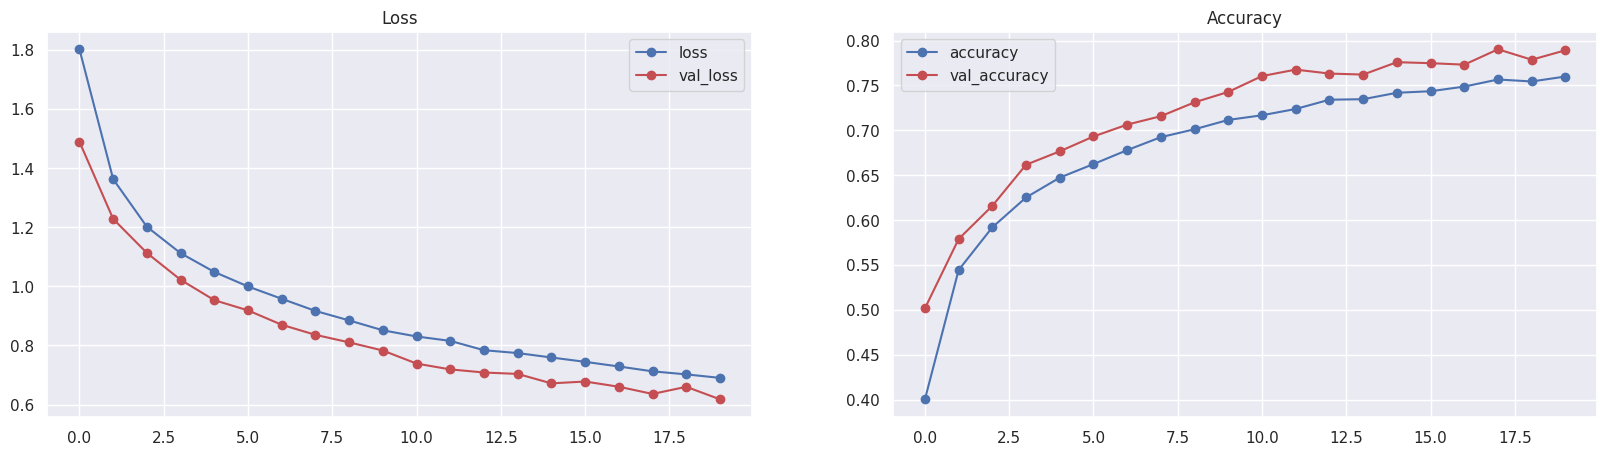

In [ ]:
featurenet_model_rgb_b100_2layer = performFeatureNet(X_rgb_b100_train, Y_train, X_rgb_b100_val, Y_val, num_layers=2)

Epoch 1/20
227/227 [==============================] - 4s 11ms/step - loss: 1.7997 - accuracy: 0.4002 - val_loss: 1.4540 - val_accuracy: 0.5254
Epoch 2/20
227/227 [==============================] - 2s 10ms/step - loss: 1.3760 - accuracy: 0.5386 - val_loss: 1.2095 - val_accuracy: 0.5900
Epoch 3/20
227/227 [==============================] - 3s 12ms/step - loss: 1.2181 - accuracy: 0.5831 - val_loss: 1.0881 - val_accuracy: 0.6291
Epoch 4/20
227/227 [==============================] - 3s 15ms/step - loss: 1.1436 - accuracy: 0.6072 - val_loss: 1.0376 - val_accuracy: 0.6369
Epoch 5/20
227/227 [==============================] - 2s 11ms/step - loss: 1.0728 - accuracy: 0.6366 - val_loss: 0.9828 - val_accuracy: 0.6573
Epoch 6/20
227/227 [==============================] - 2s 10ms/step - loss: 1.0228 - accuracy: 0.6537 - val_loss: 0.9035 - val_accuracy: 0.6904
Epoch 7/20
227/227 [==============================] - 2s 10ms/step - loss: 0.9782 - accuracy: 0.6680 - val_loss: 0.8514 - val_accuracy: 0.7075

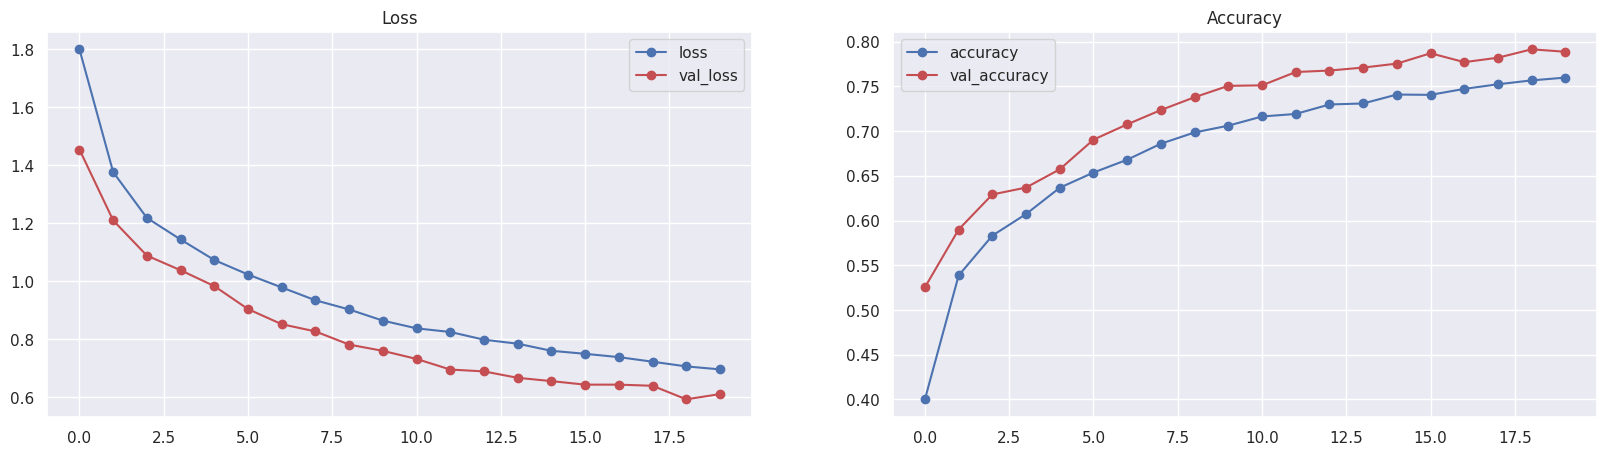

In [ ]:
featurenet_model_rgb_b100_3layer = performFeatureNet(X_rgb_b100_train, Y_train, X_rgb_b100_val, Y_val, num_layers=3)

In [21]:
randomforest_model_rgb_b100 = performRandomForest(X_rgb_b100_train, Y_train, X_rgb_b100_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8      19.342324           0.0         0.070510             0.0   
7      10.352161           0.0         0.037320             0.0   
6       4.532772           0.0         0.019017             0.0   
3       3.899275           0.0         0.018823             0.0   
5      16.804690           0.0         0.074194             0.0   

  param_max_depth param_n_estimators                                 params  \
8               7                200  {'max_depth': 7, 'n_estimators': 200}   
7               7                100  {'max_depth': 7, 'n_estimators': 100}   
6               7                 50   {'max_depth': 7, 'n_estimators': 50}   
3               6                 50   {'max_depth': 6, 'n_estimators': 50}   
5               6                200  {'max_depth': 6, 'n_estimators': 200}   

   split0_test_score  mean_test_score  std_test_score  rank_test_score  
8           0.657837         0.657837             0.0                1  
7           0.655629         0.655629             0.0                2  
6           0.650662         0.650662             0.0                3  
3           0.629139         0.629139             0.0                4  
5           0.627483         0.627483             0.0                5





Train Accuracy: 68.35%
Validation Accuracy: 69.15%


#### Train + Validation Performance of LAB B100

In [11]:
X_lab_b100_train = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_labhist_b100_prob.csv'
])
print('Train:', X_lab_b100_train.shape, Y_train.shape)

X_lab_b100_val = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_labhist_b100_prob.csv'
])
print('Validation:', X_lab_b100_val.shape, Y_val.shape)

X_lab_b100_test = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_labhist_b100_prob.csv'
])
print('Test:', X_lab_b100_test.shape, Y_test.shape)

Train: (14523, 300) (14523,)
Validation: (1812, 300) (1812,)
Test: (1824, 300) (1824,)


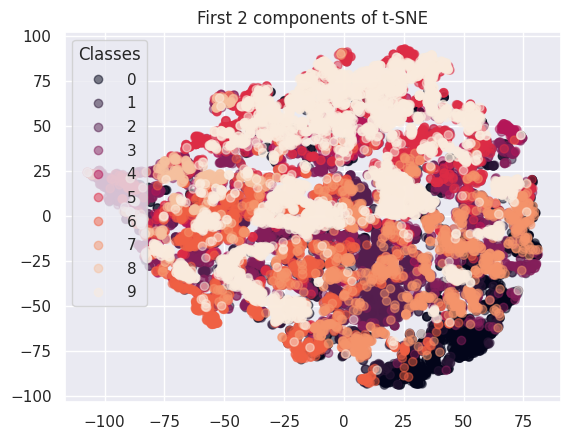

In [ ]:
displayTsne(X_lab_b100_train)

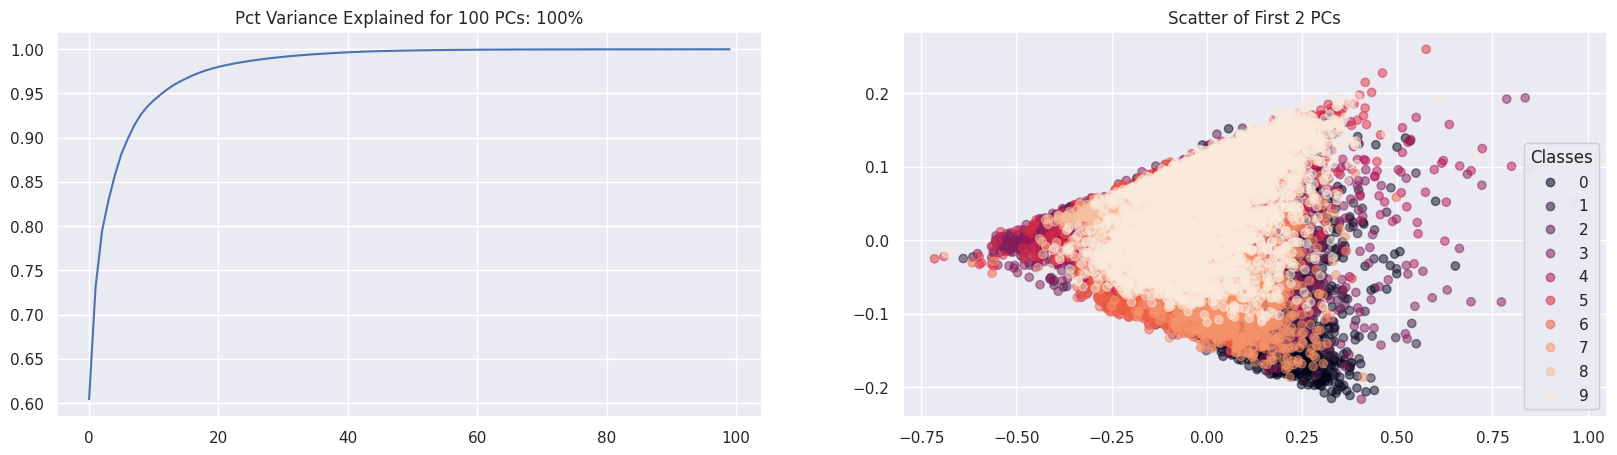

In [ ]:
lab_b100_pca, X_lab_b100_train_pca = displayPca(X_lab_b100_train)
X_lab_b100_val_pca = lab_b100_pca.transform(X_lab_b100_val)

In [12]:
logistic_model_lab_b100 = performLogisticRegression(X_lab_b100_train, Y_train, X_lab_b100_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       21.021514           0.0         0.009030             0.0   
3       10.642334           0.0         0.004216             0.0   
11      19.921023           0.0         0.004282             0.0   
1        3.481777           0.0         0.004237             0.0   
9        8.711855           0.0         0.004086             0.0   

   param_class_weight param_max_iter param_penalty  \
5                None            500          None   
3                None            250          None   
11           balanced            500          None   
1                None            100          None   
9            balanced            250          None   

                                               params  split0_test_score  \
5   {'class_weight': None, 'max_iter': 500, 'penal...           0.722958   
3   {'class_weight': None, 'max_iter': 250, 'penal...           0.695916   
11  {'class_weight': 'balanced', 'max_iter': 500, ...           0.684327   
1   {'class_weight': None, 'max_iter': 100, 'penal...           0.639625   
9   {'class_weight': 'balanced', 'max_iter': 250, ...           0.636865   

    mean_test_score  std_test_score  rank_test_score  
5          0.722958             0.0                1  
3          0.695916             0.0                2  
11         0.684327             0.0                3  
1          0.639625             0.0                4  
9          0.636865             0.0                5





Train Accuracy: 73.28%
Validation Accuracy: 71.91%


Epoch 1/20
227/227 [==============================] - 3s 11ms/step - loss: 1.6442 - accuracy: 0.4571 - val_loss: 1.3284 - val_accuracy: 0.5706
Epoch 2/20
227/227 [==============================] - 2s 10ms/step - loss: 1.1684 - accuracy: 0.6181 - val_loss: 0.9887 - val_accuracy: 0.6727
Epoch 3/20
227/227 [==============================] - 3s 12ms/step - loss: 0.9777 - accuracy: 0.6759 - val_loss: 0.8563 - val_accuracy: 0.7196
Epoch 4/20
227/227 [==============================] - 3s 14ms/step - loss: 0.8802 - accuracy: 0.7089 - val_loss: 0.7758 - val_accuracy: 0.7368
Epoch 5/20
227/227 [==============================] - 2s 9ms/step - loss: 0.8082 - accuracy: 0.7279 - val_loss: 0.7441 - val_accuracy: 0.7555
Epoch 6/20
227/227 [==============================] - 2s 10ms/step - loss: 0.7618 - accuracy: 0.7428 - val_loss: 0.6747 - val_accuracy: 0.7666
Epoch 7/20
227/227 [==============================] - 2s 10ms/step - loss: 0.7205 - accuracy: 0.7545 - val_loss: 0.6465 - val_accuracy: 0.7759


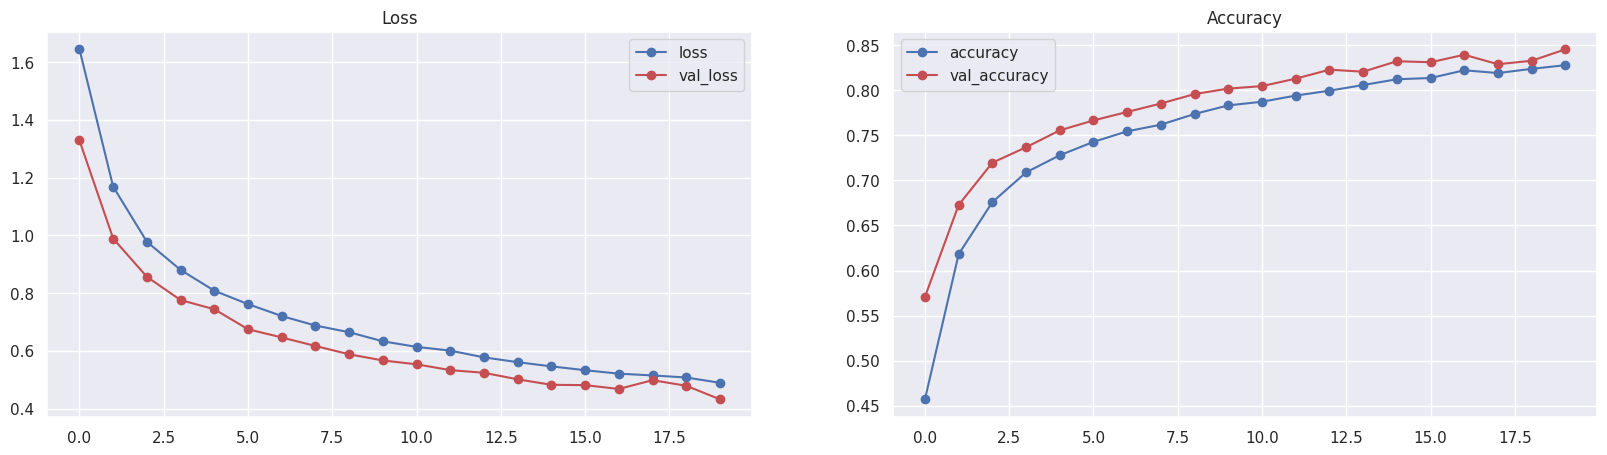

In [ ]:
featurenet_model_lab_b100_2layer = performFeatureNet(X_lab_b100_train, Y_train, X_lab_b100_val, Y_val, num_layers=2)

Epoch 1/20
227/227 [==============================] - 4s 11ms/step - loss: 1.6821 - accuracy: 0.4469 - val_loss: 1.2766 - val_accuracy: 0.5762
Epoch 2/20
227/227 [==============================] - 2s 10ms/step - loss: 1.1876 - accuracy: 0.6119 - val_loss: 0.9844 - val_accuracy: 0.6661
Epoch 3/20
227/227 [==============================] - 2s 10ms/step - loss: 0.9950 - accuracy: 0.6709 - val_loss: 0.8295 - val_accuracy: 0.7158
Epoch 4/20
227/227 [==============================] - 3s 13ms/step - loss: 0.8928 - accuracy: 0.6994 - val_loss: 0.7575 - val_accuracy: 0.7395
Epoch 5/20
227/227 [==============================] - 3s 14ms/step - loss: 0.8081 - accuracy: 0.7249 - val_loss: 0.6994 - val_accuracy: 0.7594
Epoch 6/20
227/227 [==============================] - 2s 10ms/step - loss: 0.7668 - accuracy: 0.7420 - val_loss: 0.6260 - val_accuracy: 0.7826
Epoch 7/20
227/227 [==============================] - 2s 10ms/step - loss: 0.7284 - accuracy: 0.7527 - val_loss: 0.6280 - val_accuracy: 0.7826

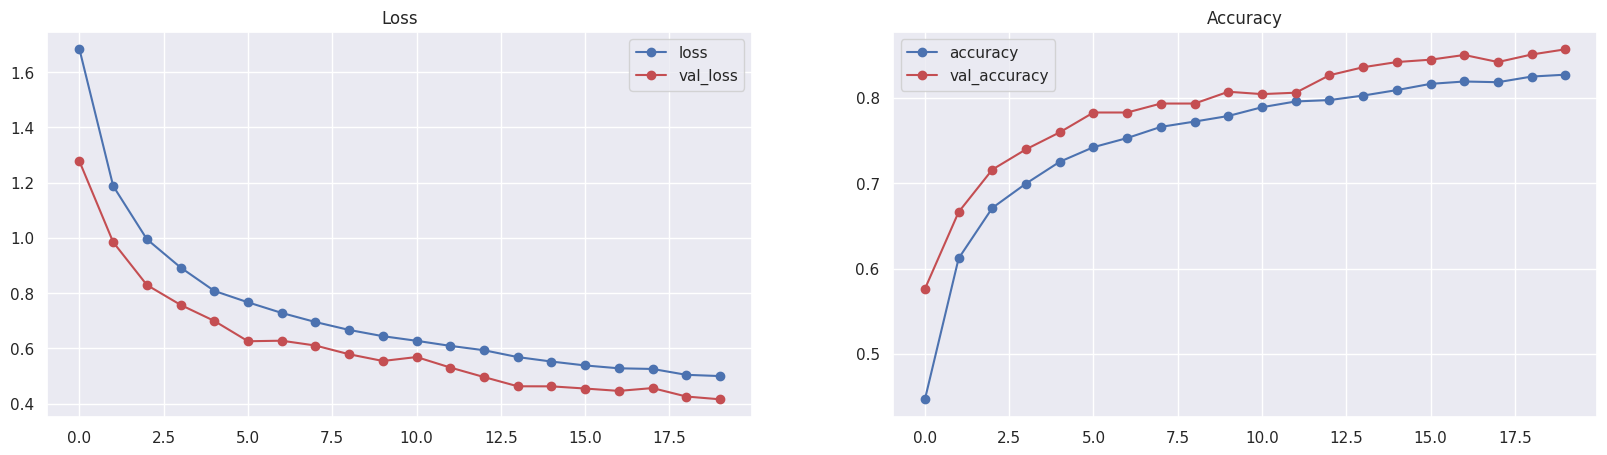

In [ ]:
featurenet_model_lab_b100_3layer = performFeatureNet(X_lab_b100_train, Y_train, X_lab_b100_val, Y_val, num_layers=3)

In [23]:
randomforest_model_lab_b100 = performRandomForest(X_lab_b100_train, Y_train, X_lab_b100_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8      13.671064           0.0         0.071863             0.0   
6       3.186182           0.0         0.019846             0.0   
7       6.133943           0.0         0.037745             0.0   
4       6.525395           0.0         0.034602             0.0   
5      11.834303           0.0         0.091371             0.0   

  param_max_depth param_n_estimators                                 params  \
8               7                200  {'max_depth': 7, 'n_estimators': 200}   
6               7                 50   {'max_depth': 7, 'n_estimators': 50}   
7               7                100  {'max_depth': 7, 'n_estimators': 100}   
4               6                100  {'max_depth': 6, 'n_estimators': 100}   
5               6                200  {'max_depth': 6, 'n_estimators': 200}   

   split0_test_score  mean_test_score  std_test_score  rank_test_score  
8           0.754967         0.754967             0.0                1  
6           0.747241         0.747241             0.0                2  
7           0.745585         0.745585             0.0                3  
4           0.716336         0.716336             0.0                4  
5           0.711369         0.711369             0.0                5





Train Accuracy: 78.48%
Validation Accuracy: 78.09%


#### Comparing Performances

##### Performance Table for RGB B100

| Model | Training Accuracy | Validation Accuracy | Time Taken to Fit |
| --- | --- | --- | --- |
| Logistic Regression | 67.76% | 67.94% | 22.74 s |
| FeatureNet | 76.00% | 78.92% | 51.79 s |
| Random Forest | 68.35% | 69.15% | 19.34 s |

##### Performance Table for LAB B100

| Model | Training Accuracy | Validation Accuracy | Time Taken to Fit |
| --- | --- | --- | --- |
| Logistic Regression | 73.28% | 71.91% | 21.02 s |
| FeatureNet | 82.68% | 85.65% | 53.03 s |
| Random Forest | 78.48% | 78.09% | 13.67 s |

### LAB B100 vs LAB B50

#### Train + Validation Performance of LAB B50

In [13]:
X_lab_b50_train = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_labhist_b50_prob.csv'
])
print('Train:', X_lab_b50_train.shape, Y_train.shape)

X_lab_b50_val = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_labhist_b50_prob.csv'
])
print('Validation:', X_lab_b50_val.shape, Y_val.shape)

X_lab_b50_test = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_labhist_b50_prob.csv'
])
print('Test:', X_lab_b50_test.shape, Y_test.shape)

Train: (14523, 150) (14523,)
Validation: (1812, 150) (1812,)
Test: (1824, 150) (1824,)


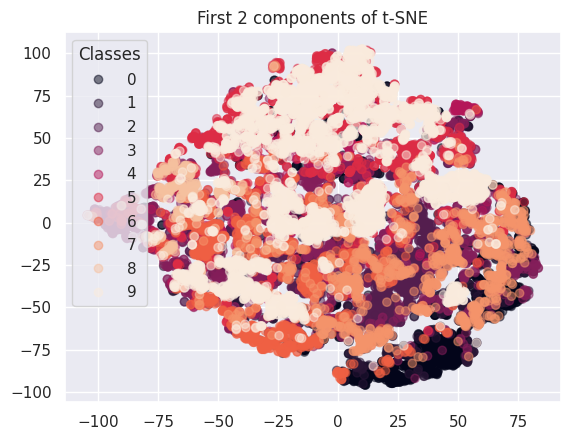

In [ ]:
displayTsne(X_lab_b50_train)

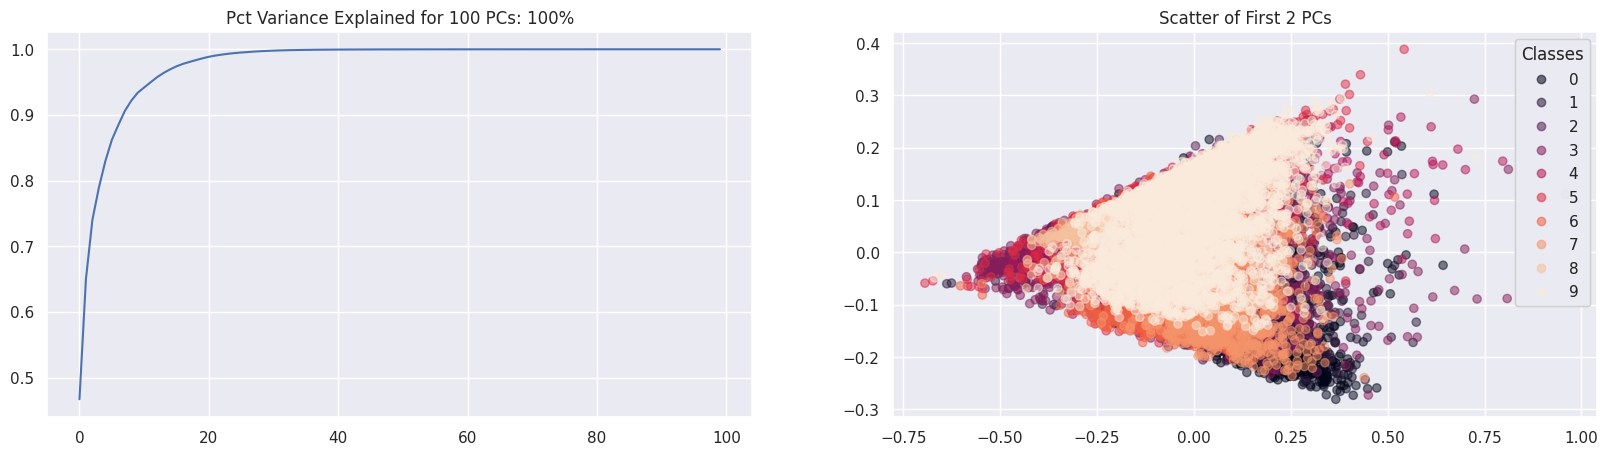

In [ ]:
lab_b50_pca, X_lab_b50_train_pca = displayPca(X_lab_b50_train)
X_lab_b50_val_pca = lab_b50_pca.transform(X_lab_b50_val)

In [14]:
logistic_model_lab_b50 = performLogisticRegression(X_lab_b50_train, Y_train, X_lab_b50_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       10.650917           0.0         0.009266             0.0   
3        4.949853           0.0         0.002849             0.0   
11      12.271500           0.0         0.002860             0.0   
1        4.859220           0.0         0.005581             0.0   
9        6.493785           0.0         0.004136             0.0   

   param_class_weight param_max_iter param_penalty  \
5                None            500          None   
3                None            250          None   
11           balanced            500          None   
1                None            100          None   
9            balanced            250          None   

                                               params  split0_test_score  \
5   {'class_weight': None, 'max_iter': 500, 'penal...           0.713576   
3   {'class_weight': None, 'max_iter': 250, 'penal...           0.678808   
11  {'class_weight': 'balanced', 'max_iter': 500, ...           0.656181   
1   {'class_weight': None, 'max_iter': 100, 'penal...           0.641832   
9   {'class_weight': 'balanced', 'max_iter': 250, ...           0.633554   

    mean_test_score  std_test_score  rank_test_score  
5          0.713576             0.0                1  
3          0.678808             0.0                2  
11         0.656181             0.0                3  
1          0.641832             0.0                4  
9          0.633554             0.0                5





Train Accuracy: 71.90%
Validation Accuracy: 72.41%


Epoch 1/20
227/227 [==============================] - 4s 12ms/step - loss: 1.6043 - accuracy: 0.4706 - val_loss: 1.2494 - val_accuracy: 0.5971
Epoch 2/20
227/227 [==============================] - 2s 9ms/step - loss: 1.1448 - accuracy: 0.6216 - val_loss: 0.9976 - val_accuracy: 0.6700
Epoch 3/20
227/227 [==============================] - 2s 8ms/step - loss: 0.9565 - accuracy: 0.6796 - val_loss: 0.8391 - val_accuracy: 0.7108
Epoch 4/20
227/227 [==============================] - 2s 9ms/step - loss: 0.8600 - accuracy: 0.7078 - val_loss: 0.7738 - val_accuracy: 0.7340
Epoch 5/20
227/227 [==============================] - 2s 8ms/step - loss: 0.7976 - accuracy: 0.7333 - val_loss: 0.7135 - val_accuracy: 0.7517
Epoch 6/20
227/227 [==============================] - 2s 10ms/step - loss: 0.7554 - accuracy: 0.7440 - val_loss: 0.7041 - val_accuracy: 0.7456
Epoch 7/20
227/227 [==============================] - 3s 13ms/step - loss: 0.7165 - accuracy: 0.7516 - val_loss: 0.6440 - val_accuracy: 0.7721
Epo

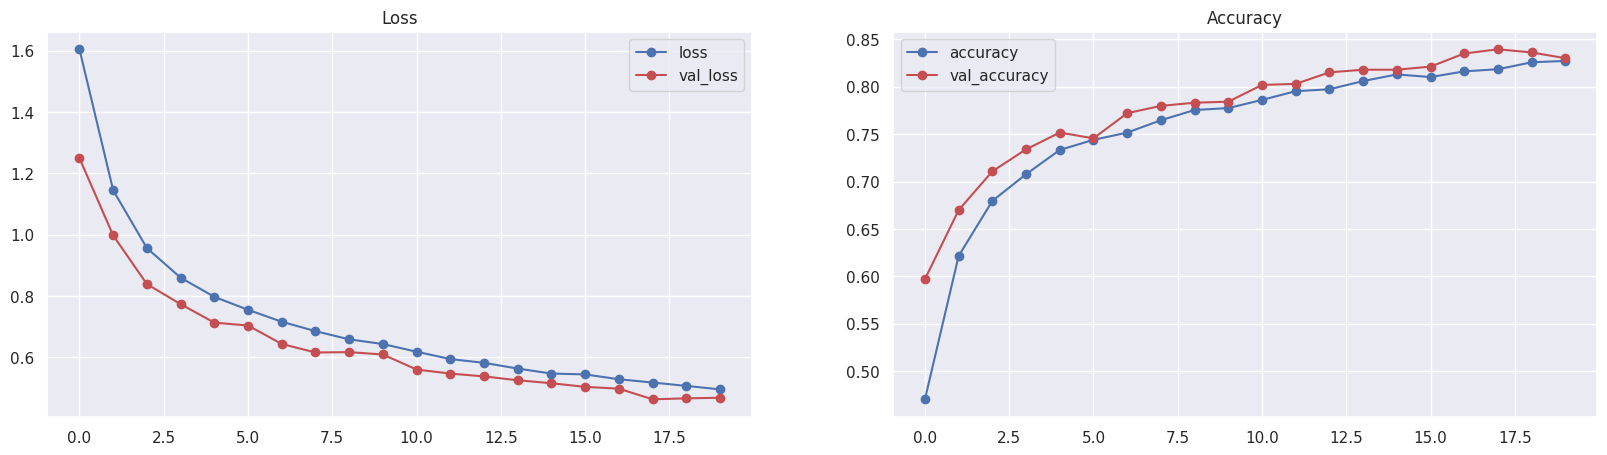

In [ ]:
featurenet_model_lab_b50_2layer = performFeatureNet(X_lab_b50_train, Y_train, X_lab_b50_val, Y_val, num_layers=2)

Epoch 1/20
227/227 [==============================] - 5s 15ms/step - loss: 1.6680 - accuracy: 0.4546 - val_loss: 1.3162 - val_accuracy: 0.5762
Epoch 2/20
227/227 [==============================] - 2s 10ms/step - loss: 1.2138 - accuracy: 0.6037 - val_loss: 0.9865 - val_accuracy: 0.6711
Epoch 3/20
227/227 [==============================] - 2s 9ms/step - loss: 1.0104 - accuracy: 0.6627 - val_loss: 0.9391 - val_accuracy: 0.6755
Epoch 4/20
227/227 [==============================] - 2s 9ms/step - loss: 0.8982 - accuracy: 0.6955 - val_loss: 0.7462 - val_accuracy: 0.7395
Epoch 5/20
227/227 [==============================] - 2s 9ms/step - loss: 0.8307 - accuracy: 0.7170 - val_loss: 0.6987 - val_accuracy: 0.7632
Epoch 6/20
227/227 [==============================] - 2s 11ms/step - loss: 0.7812 - accuracy: 0.7367 - val_loss: 0.6470 - val_accuracy: 0.7770
Epoch 7/20
227/227 [==============================] - 3s 14ms/step - loss: 0.7303 - accuracy: 0.7518 - val_loss: 0.6191 - val_accuracy: 0.7837
Ep

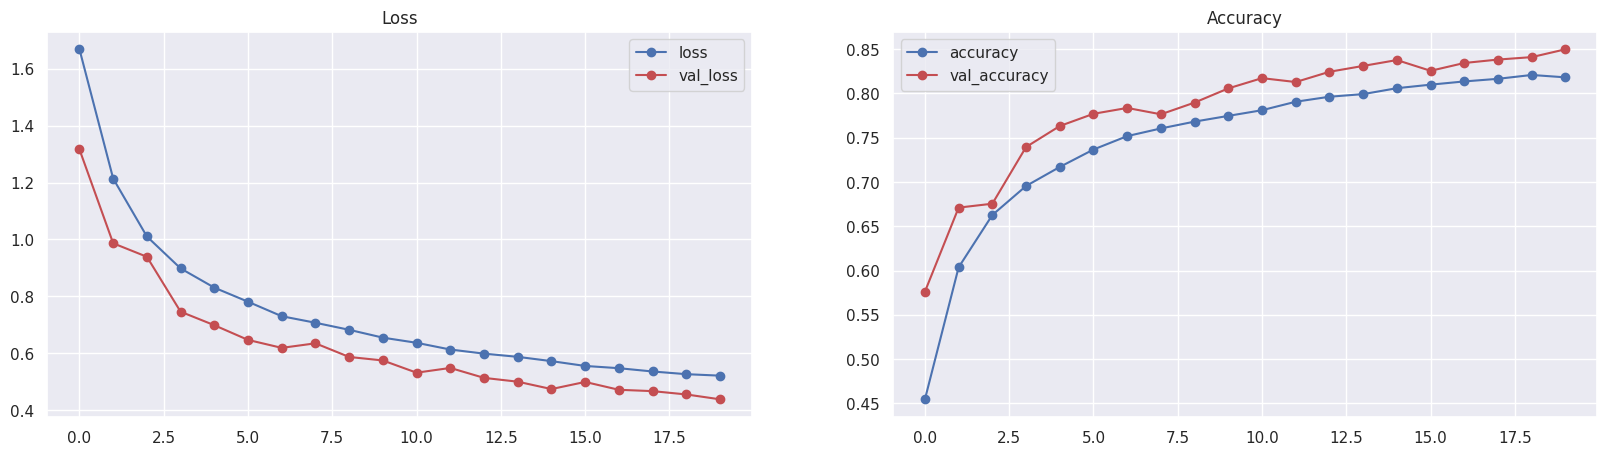

In [ ]:
featurenet_model_lab_b50_3layer = performFeatureNet(X_lab_b50_train, Y_train, X_lab_b50_val, Y_val, num_layers=3)

In [25]:
randomforest_model_lab_b50 = performRandomForest(X_lab_b50_train, Y_train, X_lab_b50_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8      11.045128           0.0         0.065425             0.0   
7       4.778221           0.0         0.033930             0.0   
6       3.337449           0.0         0.017781             0.0   
4       5.295937           0.0         0.032631             0.0   
5       9.480058           0.0         0.086874             0.0   

  param_max_depth param_n_estimators                                 params  \
8               7                200  {'max_depth': 7, 'n_estimators': 200}   
7               7                100  {'max_depth': 7, 'n_estimators': 100}   
6               7                 50   {'max_depth': 7, 'n_estimators': 50}   
4               6                100  {'max_depth': 6, 'n_estimators': 100}   
5               6                200  {'max_depth': 6, 'n_estimators': 200}   

   split0_test_score  mean_test_score  std_test_score  rank_test_score  
8           0.738962         0.738962             0.0                1  
7           0.733996         0.733996             0.0                2  
6           0.730132         0.730132             0.0                3  
4           0.718543         0.718543             0.0                4  
5           0.708057         0.708057             0.0                5





Train Accuracy: 77.56%
Validation Accuracy: 77.76%


#### Comparing Performances

##### Performance Table for LAB B100

| Model | Training Accuracy | Validation Accuracy | Time Taken to Fit |
| --- | --- | --- | --- |
| Logistic Regression | 73.28% | 71.91% | 21.02 s |
| FeatureNet | 82.68% | 85.65% | 53.03 s |
| Random Forest | 78.48% | 78.09% | 13.67 s |

##### Performance Table for LAB B50

| Model | Training Accuracy | Validation Accuracy | Time Taken to Fit |
| --- | --- | --- | --- |
| Logistic Regression | 71.90% | 72.41% | 10.65 s |
| FeatureNet | 81.82% | 84.99% | 50.80 s |
| Random Forest | 77.56% | 77.76% | 11.05 s |

### Daisy S60 vs Daisy S80

#### Train + Validation Performance of Daisy S60

In [15]:
# train
X_daisy_s60_train = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_daisy_s60_rad30_rings3_h6_o8.csv'
])
print('Train:', X_daisy_s60_train.shape, Y_train.shape)

# val
X_daisy_s60_val = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_daisy_s60_rad30_rings3_h6_o8.csv'
])
print('Validation:', X_daisy_s60_val.shape, Y_val.shape)

# test
X_daisy_s60_test = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_daisy_s60_rad30_rings3_h6_o8.csv'
])
print('Test:', X_daisy_s60_test.shape, Y_test.shape)

Train: (14523, 2432) (14523,)
Validation: (1812, 2432) (1812,)
Test: (1824, 2432) (1824,)


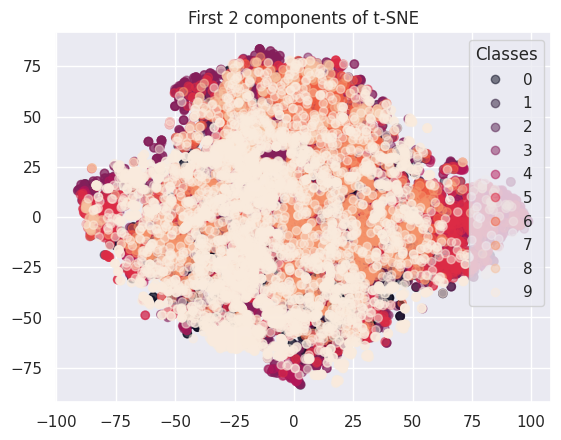

In [ ]:
displayTsne(X_daisy_s60_train)

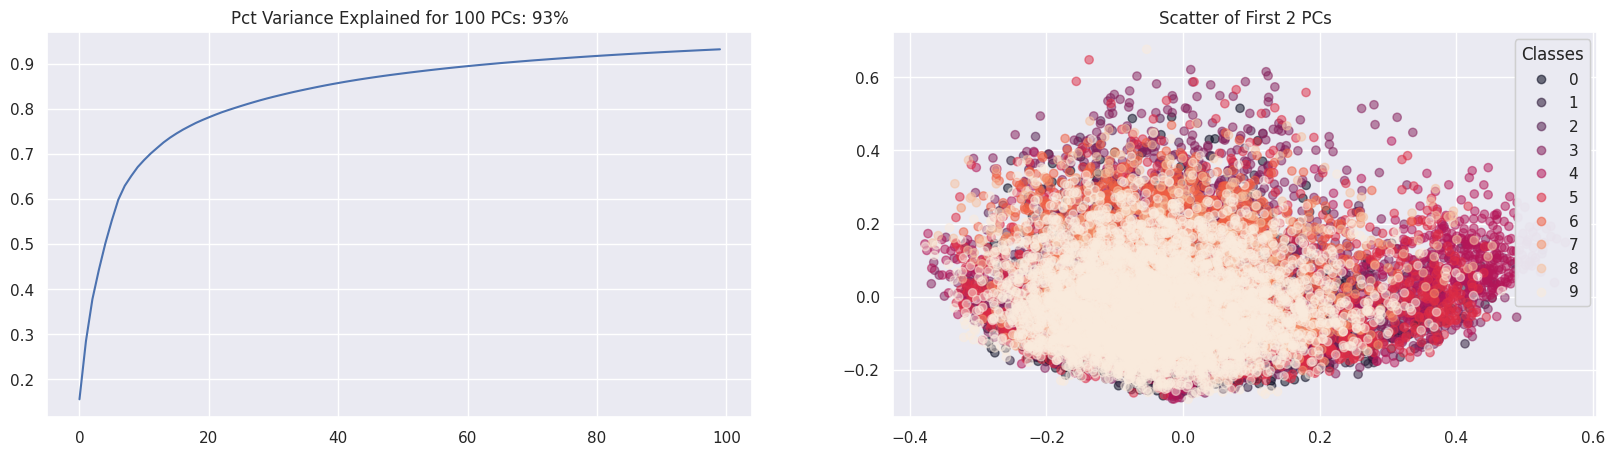

In [ ]:
daisy_s60_pca, X_daisy_s60_train_pca = displayPca(X_daisy_s60_train)
X_daisy_s60_val_pca = daisy_s60_pca.transform(X_daisy_s60_val)

In [19]:
logistic_model_daisy_s60 = performLogisticRegression(X_daisy_s60_train, Y_train, X_daisy_s60_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5      187.140987           0.0         0.065843             0.0   
11     187.575274           0.0         0.047118             0.0   
3       92.451055           0.0         0.034166             0.0   
9       95.180370           0.0         0.065477             0.0   
1       37.456282           0.0         0.054913             0.0   

   param_class_weight param_max_iter param_penalty  \
5                None            500          None   
11           balanced            500          None   
3                None            250          None   
9            balanced            250          None   
1                None            100          None   

                                               params  split0_test_score  \
5   {'class_weight': None, 'max_iter': 500, 'penal...           0.703091   
11  {'class_weight': 'balanced', 'max_iter': 500, ...           0.700883   
3   {'class_weight': None, 'max_iter': 250, 'penal...           0.687638   
9   {'class_weight': 'balanced', 'max_iter': 250, ...           0.678256   
1   {'class_weight': None, 'max_iter': 100, 'penal...           0.637969   

    mean_test_score  std_test_score  rank_test_score  
5          0.703091             0.0                1  
11         0.700883             0.0                2  
3          0.687638             0.0                3  
9          0.678256             0.0                4  
1          0.637969             0.0                5





Train Accuracy: 80.73%
Validation Accuracy: 80.96%


Epoch 1/20
227/227 [==============================] - 10s 39ms/step - loss: 1.5874 - accuracy: 0.4503 - val_loss: 1.3352 - val_accuracy: 0.5287
Epoch 2/20
227/227 [==============================] - 6s 28ms/step - loss: 1.2562 - accuracy: 0.5611 - val_loss: 1.1369 - val_accuracy: 0.5877
Epoch 3/20
227/227 [==============================] - 6s 25ms/step - loss: 1.1157 - accuracy: 0.6051 - val_loss: 1.0682 - val_accuracy: 0.6175
Epoch 4/20
227/227 [==============================] - 7s 32ms/step - loss: 1.0284 - accuracy: 0.6367 - val_loss: 1.0261 - val_accuracy: 0.6407
Epoch 5/20
227/227 [==============================] - 6s 25ms/step - loss: 0.9678 - accuracy: 0.6522 - val_loss: 0.9774 - val_accuracy: 0.6529
Epoch 6/20
227/227 [==============================] - 7s 31ms/step - loss: 0.9149 - accuracy: 0.6754 - val_loss: 0.9468 - val_accuracy: 0.6634
Epoch 7/20
227/227 [==============================] - 6s 25ms/step - loss: 0.8815 - accuracy: 0.6870 - val_loss: 0.8956 - val_accuracy: 0.681

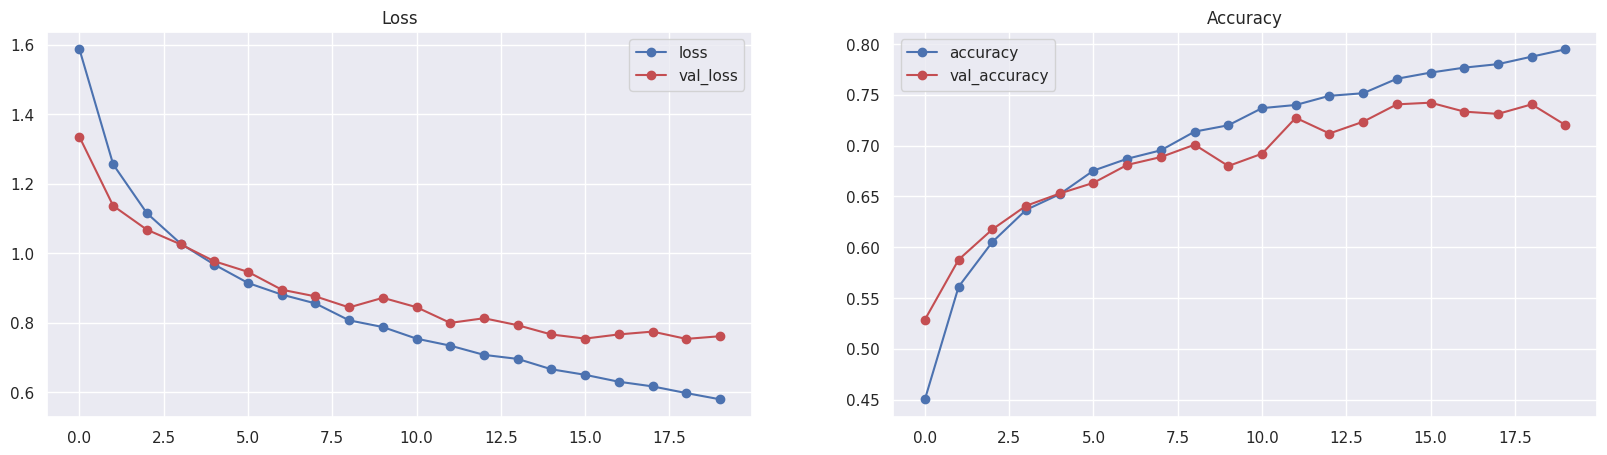

In [ ]:
featurenet_model_daisy_s60_2layer = performFeatureNet(X_daisy_s60_train, Y_train, X_daisy_s60_val, Y_val, num_layers=2)

Epoch 1/20
227/227 [==============================] - 7s 26ms/step - loss: 1.6571 - accuracy: 0.4221 - val_loss: 1.3498 - val_accuracy: 0.5353
Epoch 2/20
227/227 [==============================] - 7s 30ms/step - loss: 1.3016 - accuracy: 0.5462 - val_loss: 1.1549 - val_accuracy: 0.5927
Epoch 3/20
227/227 [==============================] - 6s 27ms/step - loss: 1.1616 - accuracy: 0.5908 - val_loss: 1.0958 - val_accuracy: 0.6021
Epoch 4/20
227/227 [==============================] - 6s 26ms/step - loss: 1.0808 - accuracy: 0.6179 - val_loss: 1.0136 - val_accuracy: 0.6407
Epoch 5/20
227/227 [==============================] - 7s 31ms/step - loss: 1.0119 - accuracy: 0.6403 - val_loss: 0.9792 - val_accuracy: 0.6518
Epoch 6/20
227/227 [==============================] - 6s 25ms/step - loss: 0.9739 - accuracy: 0.6550 - val_loss: 0.9556 - val_accuracy: 0.6634
Epoch 7/20
227/227 [==============================] - 7s 33ms/step - loss: 0.9329 - accuracy: 0.6700 - val_loss: 0.9409 - val_accuracy: 0.6634

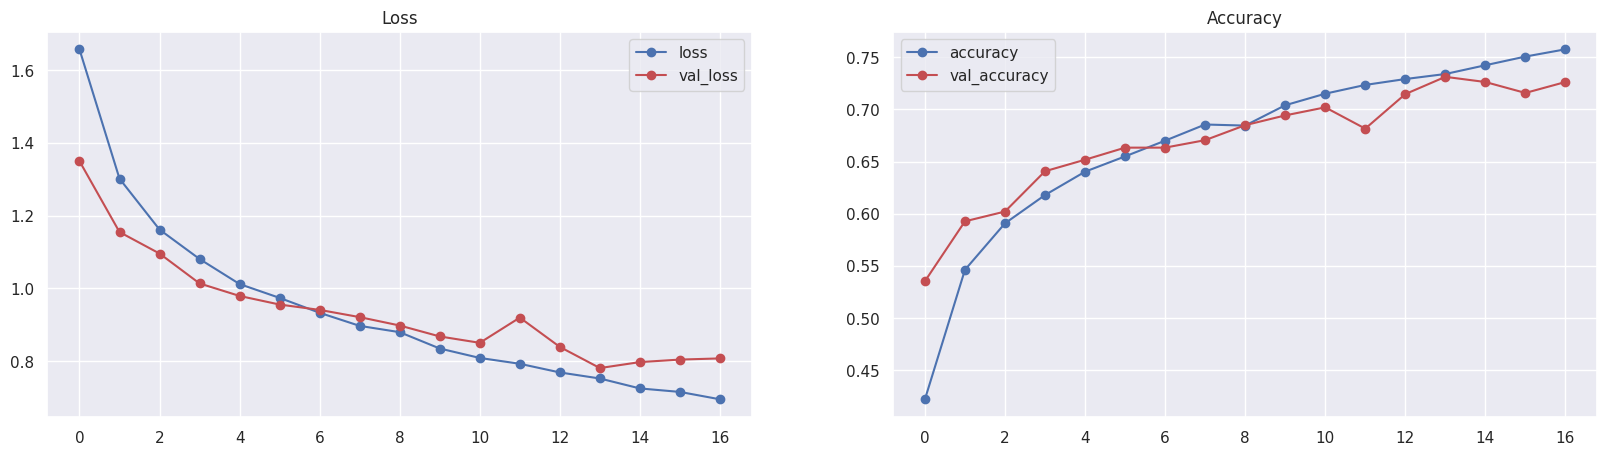

In [ ]:
featurenet_model_daisy_s60_3layer = performFeatureNet(X_daisy_s60_train, Y_train, X_daisy_s60_val, Y_val, num_layers=3)

In [27]:
randomforest_model_daisy_s60 = performRandomForest(X_daisy_s60_train, Y_train, X_daisy_s60_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8      99.340703           0.0         0.091655             0.0   
7      48.756792           0.0         0.076065             0.0   
6      25.238329           0.0         0.025225             0.0   
5      86.708798           0.0         0.089081             0.0   
4      43.287978           0.0         0.045085             0.0   

  param_max_depth param_n_estimators                                 params  \
8               7                200  {'max_depth': 7, 'n_estimators': 200}   
7               7                100  {'max_depth': 7, 'n_estimators': 100}   
6               7                 50   {'max_depth': 7, 'n_estimators': 50}   
5               6                200  {'max_depth': 6, 'n_estimators': 200}   
4               6                100  {'max_depth': 6, 'n_estimators': 100}   

   split0_test_score  mean_test_score  std_test_score  rank_test_score  
8           0.523731         0.523731             0.0                1  
7           0.522075         0.522075             0.0                2  
6           0.518212         0.518212             0.0                3  
5           0.506071         0.506071             0.0                4  
4           0.503863         0.503863             0.0                5





Train Accuracy: 58.09%
Validation Accuracy: 57.56%


#### Train + Validation Performance of Daisy S80

In [20]:
# train
X_daisy_s80_train = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_daisy_s80_rad45_rings2_h6_o8.csv'
])
print('Train:', X_daisy_s80_train.shape, Y_train.shape)

# val
X_daisy_s80_val = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_daisy_s80_rad45_rings2_h6_o8.csv'
])
print('Validation:', X_daisy_s80_val.shape, Y_val.shape)

# test
X_daisy_s80_test = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_daisy_s80_rad45_rings2_h6_o8.csv'
])
print('Test:', X_daisy_s80_test.shape, Y_test.shape)

Train: (14523, 936) (14523,)
Validation: (1812, 936) (1812,)
Test: (1824, 936) (1824,)


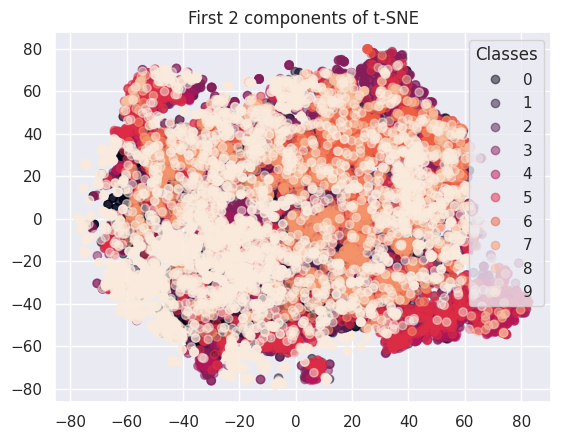

In [ ]:
displayTsne(X_daisy_s80_train)

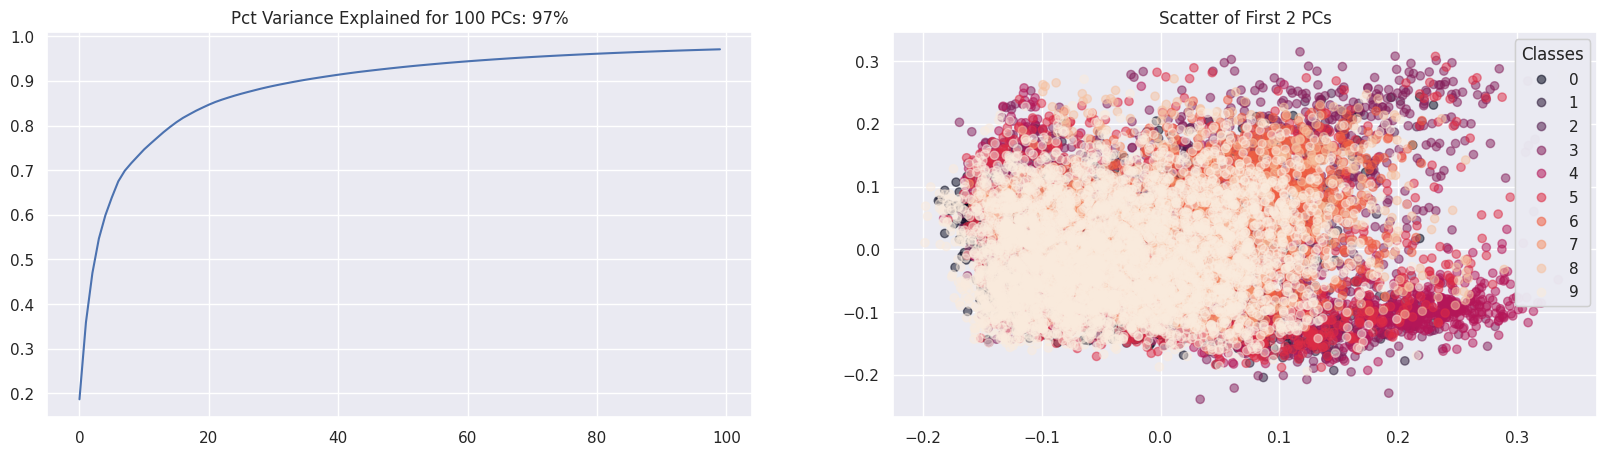

In [ ]:
daisy_s80_pca, X_daisy_s80_train_pca = displayPca(X_daisy_s80_train)
X_daisy_s80_val_pca = daisy_s80_pca.transform(X_daisy_s80_val)

In [21]:
logistic_model_daisy_s80 = performLogisticRegression(X_daisy_s80_train, Y_train, X_daisy_s80_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       66.300785           0.0         0.010755             0.0   
11      65.910460           0.0         0.010647             0.0   
3       32.727213           0.0         0.010295             0.0   
9       32.915241           0.0         0.019898             0.0   
1       13.061718           0.0         0.010446             0.0   

   param_class_weight param_max_iter param_penalty  \
5                None            500          None   
11           balanced            500          None   
3                None            250          None   
9            balanced            250          None   
1                None            100          None   

                                               params  split0_test_score  \
5   {'class_weight': None, 'max_iter': 500, 'penal...           0.701987   
11  {'class_weight': 'balanced', 'max_iter': 500, ...           0.689294   
3   {'class_weight': None, 'max_iter': 250, 'penal...           0.685982   
9   {'class_weight': 'balanced', 'max_iter': 250, ...           0.666667   
1   {'class_weight': None, 'max_iter': 100, 'penal...           0.615342   

    mean_test_score  std_test_score  rank_test_score  
5          0.701987             0.0                1  
11         0.689294             0.0                2  
3          0.685982             0.0                3  
9          0.666667             0.0                4  
1          0.615342             0.0                5





Train Accuracy: 75.29%
Validation Accuracy: 74.56%


Epoch 1/20
227/227 [==============================] - 5s 17ms/step - loss: 1.6854 - accuracy: 0.4127 - val_loss: 1.4594 - val_accuracy: 0.4812
Epoch 2/20
227/227 [==============================] - 4s 19ms/step - loss: 1.3459 - accuracy: 0.5262 - val_loss: 1.2494 - val_accuracy: 0.5651
Epoch 3/20
227/227 [==============================] - 3s 14ms/step - loss: 1.2005 - accuracy: 0.5745 - val_loss: 1.1660 - val_accuracy: 0.5833
Epoch 4/20
227/227 [==============================] - 3s 14ms/step - loss: 1.1315 - accuracy: 0.5937 - val_loss: 1.0795 - val_accuracy: 0.6214
Epoch 5/20
227/227 [==============================] - 3s 15ms/step - loss: 1.0615 - accuracy: 0.6164 - val_loss: 1.0315 - val_accuracy: 0.6297
Epoch 6/20
227/227 [==============================] - 5s 20ms/step - loss: 1.0200 - accuracy: 0.6309 - val_loss: 1.0263 - val_accuracy: 0.6220
Epoch 7/20
227/227 [==============================] - 3s 14ms/step - loss: 0.9794 - accuracy: 0.6428 - val_loss: 0.9841 - val_accuracy: 0.6462

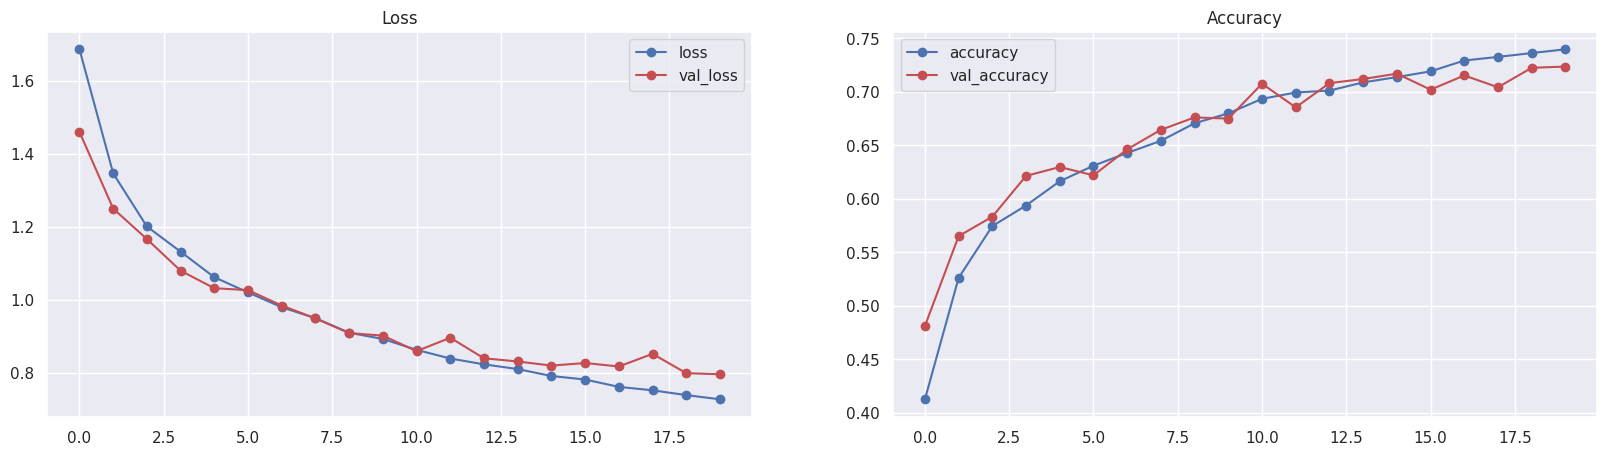

In [ ]:
featurenet_model_daisy_s80_2layer = performFeatureNet(X_daisy_s80_train, Y_train, X_daisy_s80_val, Y_val, num_layers=2)

Epoch 1/20
227/227 [==============================] - 4s 15ms/step - loss: 1.7155 - accuracy: 0.4038 - val_loss: 1.4349 - val_accuracy: 0.4956
Epoch 2/20
227/227 [==============================] - 3s 14ms/step - loss: 1.3729 - accuracy: 0.5199 - val_loss: 1.2555 - val_accuracy: 0.5591
Epoch 3/20
227/227 [==============================] - 5s 21ms/step - loss: 1.2285 - accuracy: 0.5597 - val_loss: 1.1318 - val_accuracy: 0.5911
Epoch 4/20
227/227 [==============================] - 3s 14ms/step - loss: 1.1513 - accuracy: 0.5893 - val_loss: 1.0763 - val_accuracy: 0.6065
Epoch 5/20
227/227 [==============================] - 3s 14ms/step - loss: 1.1038 - accuracy: 0.6017 - val_loss: 1.0449 - val_accuracy: 0.6159
Epoch 6/20
227/227 [==============================] - 3s 14ms/step - loss: 1.0619 - accuracy: 0.6154 - val_loss: 1.1008 - val_accuracy: 0.6026
Epoch 7/20
227/227 [==============================] - 5s 21ms/step - loss: 1.0196 - accuracy: 0.6318 - val_loss: 0.9706 - val_accuracy: 0.6385

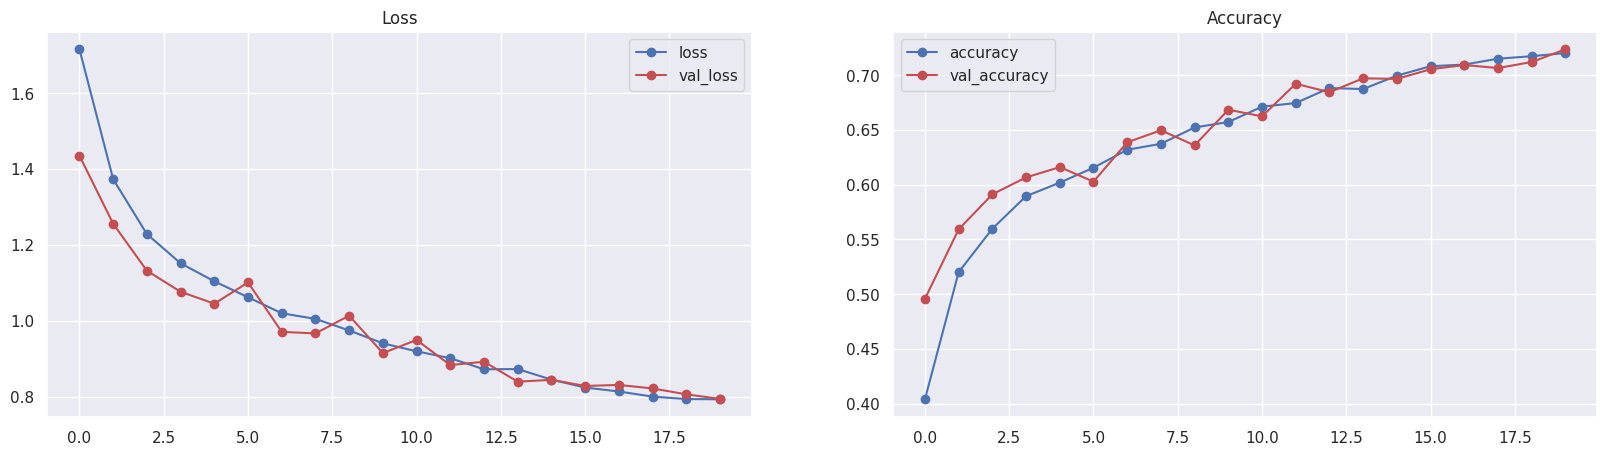

In [ ]:
featurenet_model_daisy_s80_3layer = performFeatureNet(X_daisy_s80_train, Y_train, X_daisy_s80_val, Y_val, num_layers=3)

In [29]:
randomforest_model_daisy_s80 = performRandomForest(X_daisy_s80_train, Y_train, X_daisy_s80_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8      62.148697           0.0         0.083592             0.0   
7      32.268787           0.0         0.045270             0.0   
6      15.955444           0.0         0.029440             0.0   
4      27.086124           0.0         0.051316             0.0   
3      13.798468           0.0         0.021348             0.0   

  param_max_depth param_n_estimators                                 params  \
8               7                200  {'max_depth': 7, 'n_estimators': 200}   
7               7                100  {'max_depth': 7, 'n_estimators': 100}   
6               7                 50   {'max_depth': 7, 'n_estimators': 50}   
4               6                100  {'max_depth': 6, 'n_estimators': 100}   
3               6                 50   {'max_depth': 6, 'n_estimators': 50}   

   split0_test_score  mean_test_score  std_test_score  rank_test_score  
8           0.525386         0.525386             0.0                1  
7           0.523731         0.523731             0.0                2  
6           0.522075         0.522075             0.0                3  
4           0.508278         0.508278             0.0                4  
3           0.506623         0.506623             0.0                5





Train Accuracy: 57.97%
Validation Accuracy: 57.56%


#### Comparing Performances

##### Performance Table for Daisy S60

| Model | Training Accuracy | Validation Accuracy | Time Taken to Fit |
| --- | --- | --- | --- |
| Logistic Regression | 80.73% | 80.96% | 187.14 s |
| FeatureNet | 75.76% | 72.63% | 110.07 s |
| Random Forest | 58.09% | 57.56% | 99.34 s |

##### Performance Table for Daisy S80

| Model | Training Accuracy | Validation Accuracy | Time Taken to Fit |
| --- | --- | --- | --- |
| Logistic Regression | 75.29% | 74.56% | 66.30 s |
| FeatureNet | 73.97% | 72.35% | 82.94 s |
| Random Forest | 57.97% | 57.56% | 62.15 s |

### LAB B50 + Daisy S80

#### Train + Validation Performance of LAB B50 + Daisy S80

In [10]:
# train
X_lab_daisy_train = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_labhist_b50_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_daisy_s80_rad45_rings2_h6_o8.csv'
])
print('Train:', X_lab_daisy_train.shape, Y_train.shape)

# val
X_lab_daisy_val = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_labhist_b50_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_daisy_s80_rad45_rings2_h6_o8.csv'
])
print('Validation:', X_lab_daisy_val.shape, Y_val.shape)

# test
X_lab_daisy_test = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_labhist_b50_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_daisy_s80_rad45_rings2_h6_o8.csv'
])
print('Test:', X_lab_daisy_test.shape, Y_test.shape)

Train: (14523, 1086) (14523,)
Validation: (1812, 1086) (1812,)
Test: (1824, 1086) (1824,)


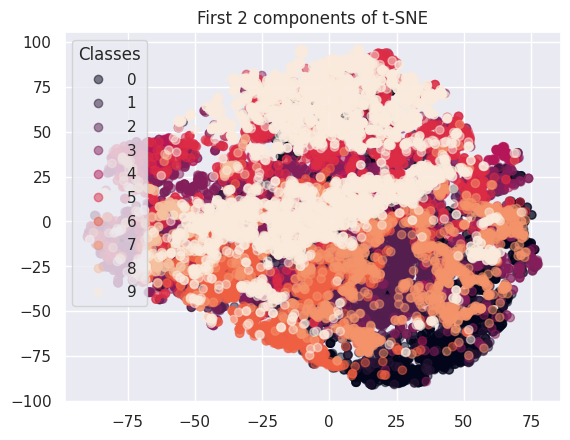

In [ ]:
displayTsne(X_lab_daisy_train)

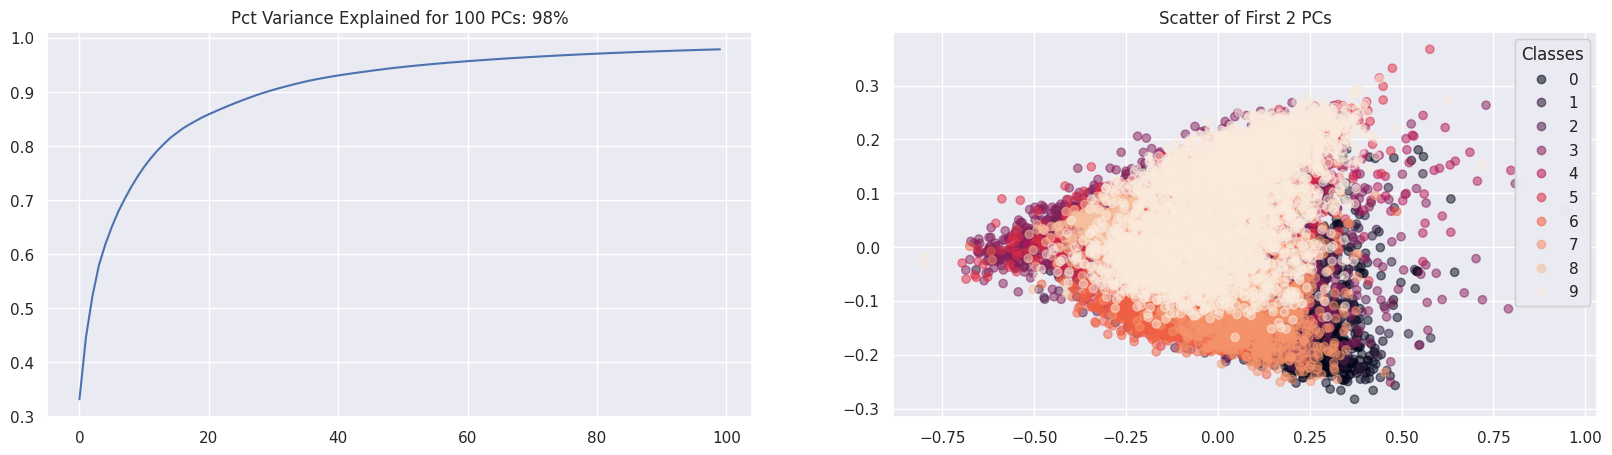

In [ ]:
lab_daisy_pca, X_lab_daisy_train_pca = displayPca(X_lab_daisy_train)
X_lab_daisy_val_pca = lab_daisy_pca.transform(X_lab_daisy_val)

In [11]:
logistic_model_lab_daisy = performLogisticRegression(X_lab_daisy_train, Y_train, X_lab_daisy_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       94.801352           0.0         0.020907             0.0   
11      94.803376           0.0         0.036572             0.0   
3       47.615134           0.0         0.019827             0.0   
9       48.610688           0.0         0.015779             0.0   
1       19.856173           0.0         0.016976             0.0   

   param_class_weight param_max_iter param_penalty  \
5                None            500          None   
11           balanced            500          None   
3                None            250          None   
9            balanced            250          None   
1                None            100          None   

                                               params  split0_test_score  \
5   {'class_weight': None, 'max_iter': 500, 'penal...           0.864790   
11  {'class_weight': 'balanced', 'max_iter': 500, ...           0.846026   
3   {'class_weight': None, 'max_iter': 250, 'penal...           0.833885   
9   {'class_weight': 'balanced', 'max_iter': 250, ...           0.820088   
1   {'class_weight': None, 'max_iter': 100, 'penal...           0.770971   

    mean_test_score  std_test_score  rank_test_score  
5          0.864790             0.0                1  
11         0.846026             0.0                2  
3          0.833885             0.0                3  
9          0.820088             0.0                4  
1          0.770971             0.0                5





Train Accuracy: 88.86%
Validation Accuracy: 89.68%


Epoch 1/20
227/227 [==============================] - 5s 16ms/step - loss: 1.4149 - accuracy: 0.5202 - val_loss: 1.0482 - val_accuracy: 0.6584
Epoch 2/20
227/227 [==============================] - 4s 19ms/step - loss: 0.9163 - accuracy: 0.6950 - val_loss: 0.7975 - val_accuracy: 0.7412
Epoch 3/20
227/227 [==============================] - 4s 18ms/step - loss: 0.7599 - accuracy: 0.7501 - val_loss: 0.6828 - val_accuracy: 0.7831
Epoch 4/20
227/227 [==============================] - 3s 15ms/step - loss: 0.6733 - accuracy: 0.7761 - val_loss: 0.6125 - val_accuracy: 0.8002
Epoch 5/20
227/227 [==============================] - 3s 15ms/step - loss: 0.6043 - accuracy: 0.7994 - val_loss: 0.5416 - val_accuracy: 0.8195
Epoch 6/20
227/227 [==============================] - 5s 20ms/step - loss: 0.5583 - accuracy: 0.8111 - val_loss: 0.5272 - val_accuracy: 0.8251
Epoch 7/20
227/227 [==============================] - 4s 17ms/step - loss: 0.5260 - accuracy: 0.8208 - val_loss: 0.4933 - val_accuracy: 0.8366

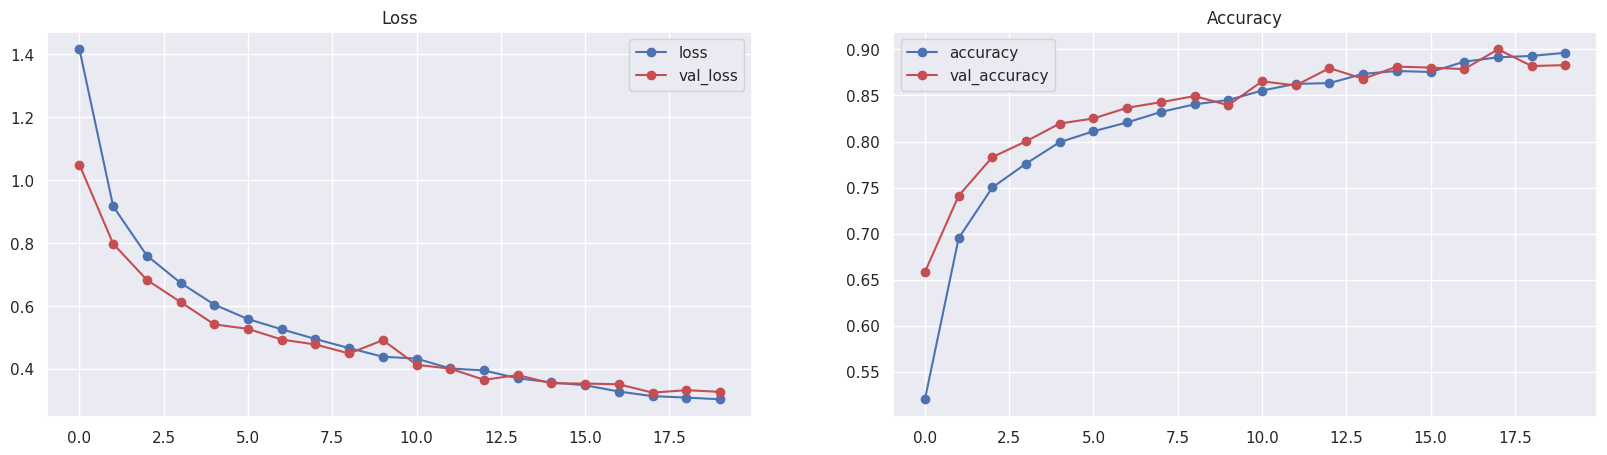

In [ ]:
featurenet_model_lab_daisy_2layer = performFeatureNet(X_lab_daisy_train, Y_train, X_lab_daisy_val, Y_val, num_layers=2)

Epoch 1/20
227/227 [==============================] - 5s 16ms/step - loss: 1.5434 - accuracy: 0.4735 - val_loss: 1.0278 - val_accuracy: 0.6545
Epoch 2/20
227/227 [==============================] - 4s 16ms/step - loss: 0.9796 - accuracy: 0.6700 - val_loss: 0.8202 - val_accuracy: 0.7274
Epoch 3/20
227/227 [==============================] - 5s 21ms/step - loss: 0.8080 - accuracy: 0.7285 - val_loss: 0.6536 - val_accuracy: 0.7881
Epoch 4/20
227/227 [==============================] - 3s 15ms/step - loss: 0.7019 - accuracy: 0.7664 - val_loss: 0.6050 - val_accuracy: 0.8013
Epoch 5/20
227/227 [==============================] - 3s 15ms/step - loss: 0.6453 - accuracy: 0.7825 - val_loss: 0.5559 - val_accuracy: 0.8162
Epoch 6/20
227/227 [==============================] - 4s 19ms/step - loss: 0.5965 - accuracy: 0.8023 - val_loss: 0.5005 - val_accuracy: 0.8262
Epoch 7/20
227/227 [==============================] - 4s 19ms/step - loss: 0.5565 - accuracy: 0.8134 - val_loss: 0.4892 - val_accuracy: 0.8400

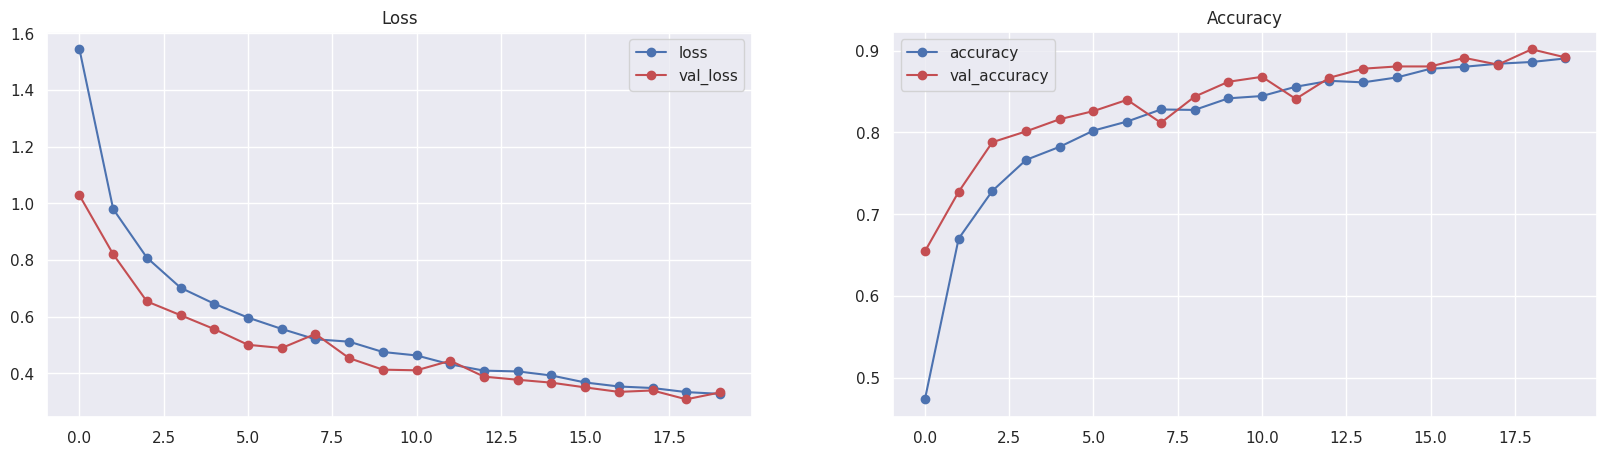

In [ ]:
featurenet_model_lab_daisy_3layer = performFeatureNet(X_lab_daisy_train, Y_train, X_lab_daisy_val, Y_val, num_layers=3)

In [31]:
randomforest_model_lab_daisy = performRandomForest(X_lab_daisy_train, Y_train, X_lab_daisy_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7      31.652507           0.0         0.042574             0.0   
8      61.880280           0.0         0.080634             0.0   
6      16.210941           0.0         0.032793             0.0   
4      27.117760           0.0         0.059474             0.0   
3      13.564257           0.0         0.029017             0.0   

  param_max_depth param_n_estimators                                 params  \
7               7                100  {'max_depth': 7, 'n_estimators': 100}   
8               7                200  {'max_depth': 7, 'n_estimators': 200}   
6               7                 50   {'max_depth': 7, 'n_estimators': 50}   
4               6                100  {'max_depth': 6, 'n_estimators': 100}   
3               6                 50   {'max_depth': 6, 'n_estimators': 50}   

   split0_test_score  mean_test_score  std_test_score  rank_test_score  
7           0.735099         0.735099             0.0                1  
8           0.735099         0.735099             0.0                1  
6           0.726269         0.726269             0.0                3  
4           0.694260         0.694260             0.0                4  
3           0.692605         0.692605             0.0                5





Train Accuracy: 77.77%
Validation Accuracy: 75.77%


#### Performance Table for LAB B50 + Daisy S80

| Model | Training Accuracy | Validation Accuracy | Time Taken to Fit |
| --- | --- | --- | --- |
| Logistic Regression | 88.86% | 89.68% | 94.80 s |
| FeatureNet | 89.06% | 89.18% | 79.27 s |
| Random Forest | 77.77% | 75.77% | 31.65 s |

### LAB B50 + Daisy S80 + Canny

#### Train + Validation Performance of LAB B50 + Daisy S80 + Canny

In [12]:
# train
X_lab_daisy_canny_train = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_labhist_b50_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_daisy_s80_rad45_rings2_h6_o8.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_canny.csv'
])
print('Train:', X_lab_daisy_canny_train.shape, Y_train.shape)

# val
X_lab_daisy_canny_val = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_labhist_b50_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_daisy_s80_rad45_rings2_h6_o8.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_canny.csv'
])
print('Validation:', X_lab_daisy_canny_val.shape, Y_val.shape)

# test
X_lab_daisy_canny_test = read_features_from_files([
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_labhist_b50_prob.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_daisy_s80_rad45_rings2_h6_o8.csv',
    '/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_canny.csv'
])
print('Test:', X_lab_daisy_canny_test.shape, Y_test.shape)

Train: (14523, 1088) (14523,)
Validation: (1812, 1088) (1812,)
Test: (1824, 1088) (1824,)


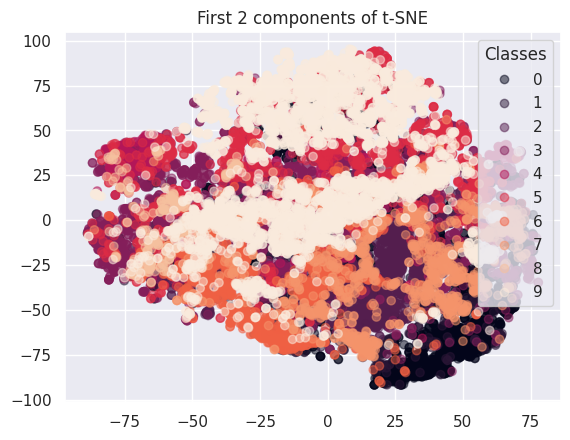

In [ ]:
displayTsne(X_lab_daisy_canny_train)

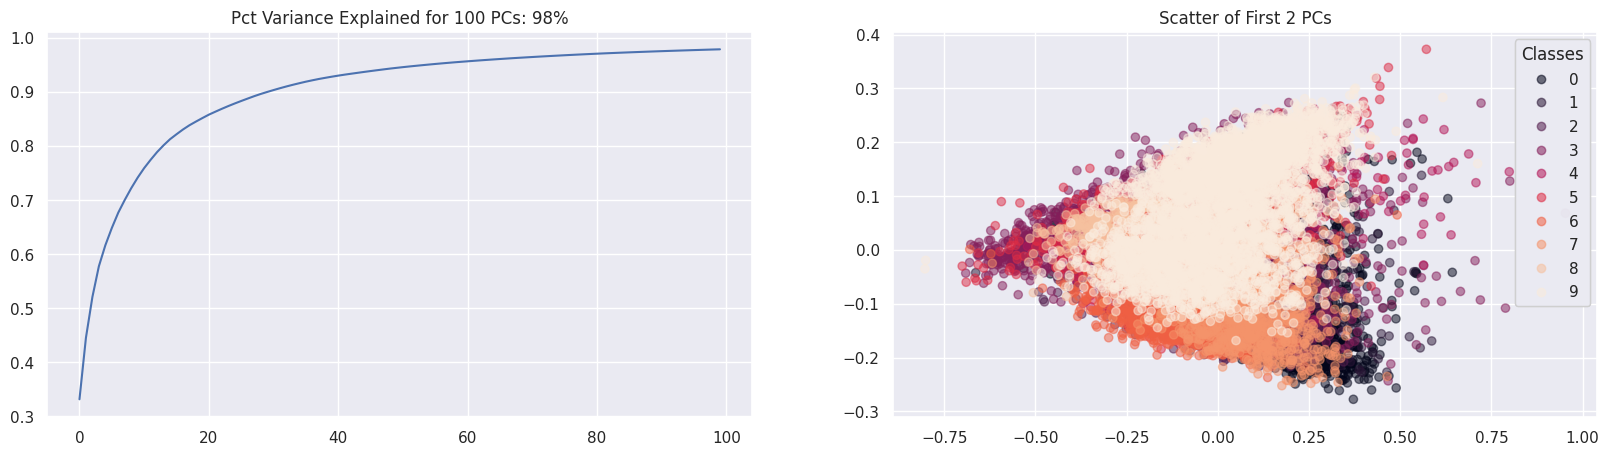

In [ ]:
lab_daisy_canny_pca, X_lab_daisy_canny_train_pca = displayPca(X_lab_daisy_canny_train)
X_lab_daisy_canny_val_pca = lab_daisy_canny_pca.transform(X_lab_daisy_canny_val)

In [13]:
logistic_model_lab_daisy_canny = performLogisticRegression(X_lab_daisy_canny_train, Y_train, X_lab_daisy_canny_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       96.953150           0.0         0.025040             0.0   
11      94.661422           0.0         0.015305             0.0   
3       48.575413           0.0         0.035928             0.0   
9       47.644454           0.0         0.020135             0.0   
1       20.697944           0.0         0.015220             0.0   

   param_class_weight param_max_iter param_penalty  \
5                None            500          None   
11           balanced            500          None   
3                None            250          None   
9            balanced            250          None   
1                None            100          None   

                                               params  split0_test_score  \
5   {'class_weight': None, 'max_iter': 500, 'penal...           0.859272   
11  {'class_weight': 'balanced', 'max_iter': 500, ...           0.849890   
3   {'class_weight': None, 'max_iter': 250, 'penal...           0.827815   
9   {'class_weight': 'balanced', 'max_iter': 250, ...           0.817881   
1   {'class_weight': None, 'max_iter': 100, 'penal...           0.765453   

    mean_test_score  std_test_score  rank_test_score  
5          0.859272             0.0                1  
11         0.849890             0.0                2  
3          0.827815             0.0                3  
9          0.817881             0.0                4  
1          0.765453             0.0                5





Train Accuracy: 88.14%
Validation Accuracy: 88.41%


Epoch 1/20
227/227 [==============================] - 5s 16ms/step - loss: 1.4481 - accuracy: 0.5147 - val_loss: 1.0176 - val_accuracy: 0.6772
Epoch 2/20
227/227 [==============================] - 5s 21ms/step - loss: 0.9350 - accuracy: 0.6910 - val_loss: 0.8045 - val_accuracy: 0.7323
Epoch 3/20
227/227 [==============================] - 4s 16ms/step - loss: 0.7756 - accuracy: 0.7429 - val_loss: 0.6811 - val_accuracy: 0.7776
Epoch 4/20
227/227 [==============================] - 3s 15ms/step - loss: 0.6756 - accuracy: 0.7748 - val_loss: 0.6338 - val_accuracy: 0.7925
Epoch 5/20
227/227 [==============================] - 3s 15ms/step - loss: 0.6154 - accuracy: 0.7967 - val_loss: 0.5466 - val_accuracy: 0.8240
Epoch 6/20
227/227 [==============================] - 5s 22ms/step - loss: 0.5719 - accuracy: 0.8056 - val_loss: 0.5657 - val_accuracy: 0.8079
Epoch 7/20
227/227 [==============================] - 4s 15ms/step - loss: 0.5376 - accuracy: 0.8178 - val_loss: 0.4972 - val_accuracy: 0.8433

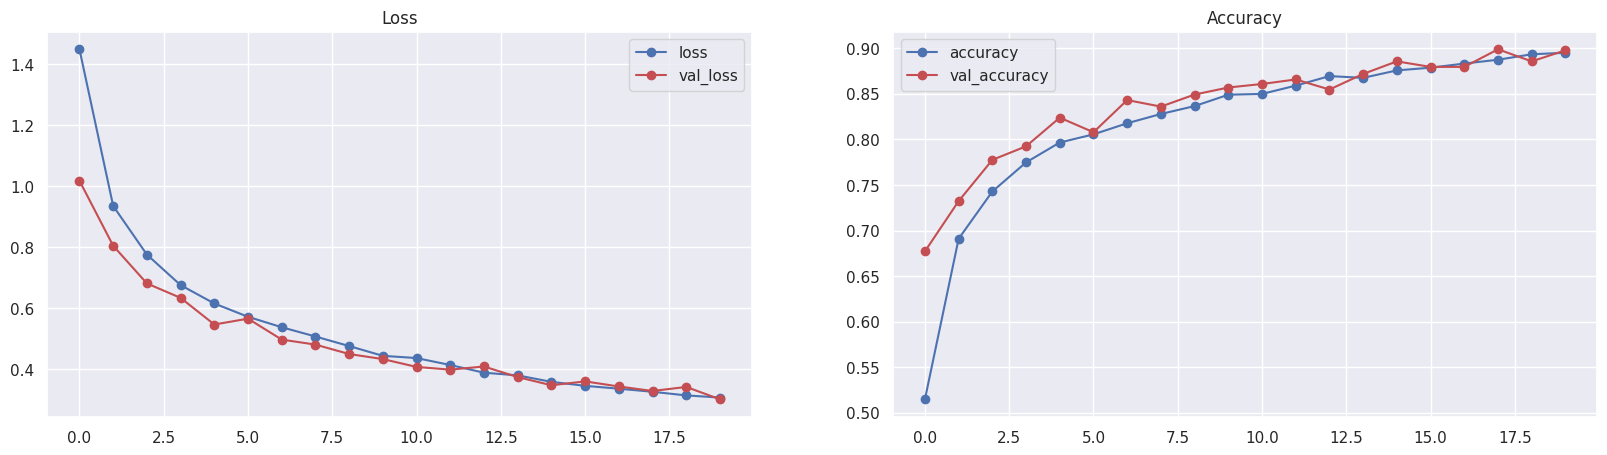

In [ ]:
featurenet_model_lab_daisy_canny_2layer = performFeatureNet(X_lab_daisy_canny_train, Y_train, X_lab_daisy_canny_val, Y_val, num_layers=2)

Epoch 1/20
227/227 [==============================] - 6s 16ms/step - loss: 1.5361 - accuracy: 0.4753 - val_loss: 1.0778 - val_accuracy: 0.6336
Epoch 2/20
227/227 [==============================] - 5s 20ms/step - loss: 0.9965 - accuracy: 0.6689 - val_loss: 0.8251 - val_accuracy: 0.7307
Epoch 3/20
227/227 [==============================] - 4s 17ms/step - loss: 0.8330 - accuracy: 0.7182 - val_loss: 0.6734 - val_accuracy: 0.7820
Epoch 4/20
227/227 [==============================] - 4s 15ms/step - loss: 0.7387 - accuracy: 0.7505 - val_loss: 0.6259 - val_accuracy: 0.7964
Epoch 5/20
227/227 [==============================] - 4s 16ms/step - loss: 0.6693 - accuracy: 0.7742 - val_loss: 0.5594 - val_accuracy: 0.8102
Epoch 6/20
227/227 [==============================] - 5s 22ms/step - loss: 0.6336 - accuracy: 0.7848 - val_loss: 0.5518 - val_accuracy: 0.8113
Epoch 7/20
227/227 [==============================] - 4s 16ms/step - loss: 0.5829 - accuracy: 0.8056 - val_loss: 0.4998 - val_accuracy: 0.8333

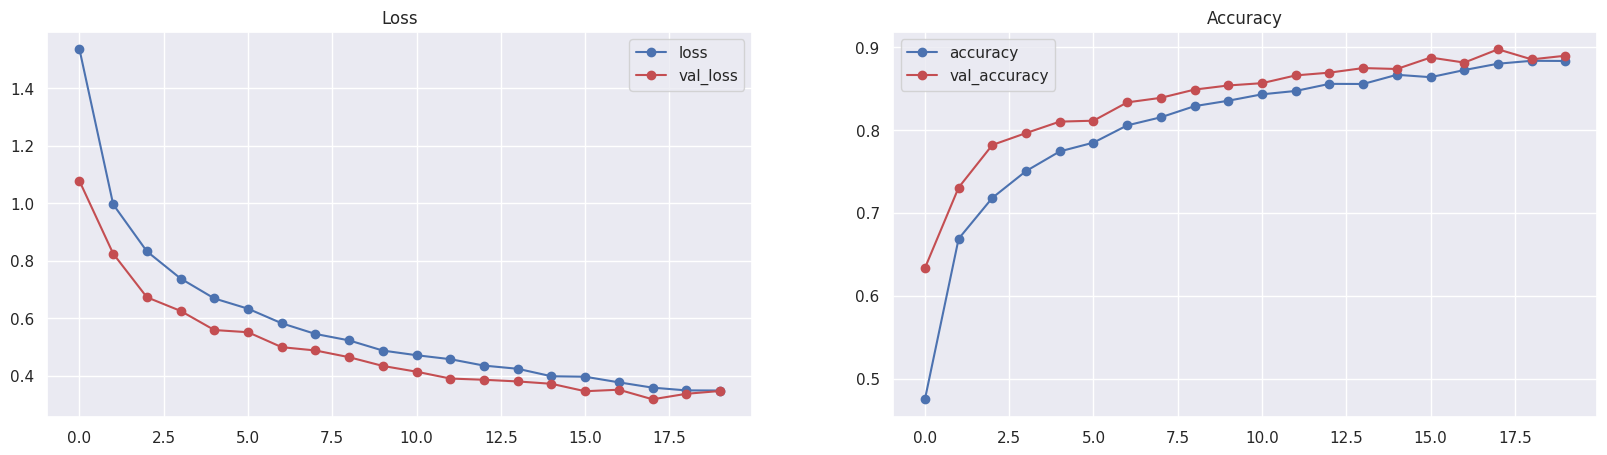

In [ ]:
featurenet_model_lab_daisy_canny_3layer = performFeatureNet(X_lab_daisy_canny_train, Y_train, X_lab_daisy_canny_val, Y_val, num_layers=3)

In [33]:
randomforest_model_lab_daisy_canny = performRandomForest(X_lab_daisy_canny_train, Y_train, X_lab_daisy_canny_val, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8      63.768959           0.0         0.110311             0.0   
7      31.437970           0.0         0.044893             0.0   
6      15.669872           0.0         0.022672             0.0   
5      54.811944           0.0         0.077097             0.0   
3      13.923786           0.0         0.020197             0.0   

  param_max_depth param_n_estimators                                 params  \
8               7                200  {'max_depth': 7, 'n_estimators': 200}   
7               7                100  {'max_depth': 7, 'n_estimators': 100}   
6               7                 50   {'max_depth': 7, 'n_estimators': 50}   
5               6                200  {'max_depth': 6, 'n_estimators': 200}   
3               6                 50   {'max_depth': 6, 'n_estimators': 50}   

   split0_test_score  mean_test_score  std_test_score  rank_test_score  
8           0.737859         0.737859             0.0                1  
7           0.735099         0.735099             0.0                2  
6           0.711369         0.711369             0.0                3  
5           0.698124         0.698124             0.0                4  
3           0.694812         0.694812             0.0                5





Train Accuracy: 78.37%
Validation Accuracy: 77.54%


#### Performance Table for LAB B50 + Daisy S80 + Canny

| Model | Training Accuracy | Validation Accuracy | Time Taken to Fit |
| --- | --- | --- | --- |
| Logistic Regression | 88.14% | 88.41% | 96.95 s |
| FeatureNet | 89.52% | 89.79% | 78.76 s |
| Random Forest | 78.37% | 77.54% | 63.77 s |

### (LAB B50 + Daisy S80 + Canny) 25 PCs vs 100 PCs

#### Train + Validation Performance of 25 PCs of PCA for LAB B50 + Daisy S80 + Canny

In [14]:
lab_daisy_canny_pca_25, X_lab_daisy_canny_train_pca_25 = displayPca(X_lab_daisy_canny_train, num_components = 25, display_pca = False)
X_lab_daisy_canny_val_pca_25 = lab_daisy_canny_pca_25.transform(X_lab_daisy_canny_val)

In [15]:
logistic_model_lab_daisy_canny_pca_25 = performLogisticRegression(X_lab_daisy_canny_train_pca_25, Y_train, X_lab_daisy_canny_val_pca_25, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5        6.499428           0.0         0.002357             0.0   
3        2.168310           0.0         0.001707             0.0   
1        0.892974           0.0         0.007914             0.0   
11       4.134881           0.0         0.001678             0.0   
9        4.568938           0.0         0.001818             0.0   

   param_class_weight param_max_iter param_penalty  \
5                None            500          None   
3                None            250          None   
1                None            100          None   
11           balanced            500          None   
9            balanced            250          None   

                                               params  split0_test_score  \
5   {'class_weight': None, 'max_iter': 500, 'penal...           0.698675   
3   {'class_weight': None, 'max_iter': 250, 'penal...           0.697020   
1   {'class_weight': None, 'max_iter': 100, 'penal...           0.692605   
11  {'class_weight': 'balanced', 'max_iter': 500, ...           0.657285   
9   {'class_weight': 'balanced', 'max_iter': 250, ...           0.655077   

    mean_test_score  std_test_score  rank_test_score  
5          0.698675             0.0                1  
3          0.697020             0.0                2  
1          0.692605             0.0                3  
11         0.657285             0.0                4  
9          0.655077             0.0                5





Train Accuracy: 70.74%
Validation Accuracy: 70.25%


Epoch 1/20
227/227 [==============================] - 4s 13ms/step - loss: 1.3269 - accuracy: 0.5652 - val_loss: 1.0005 - val_accuracy: 0.6672
Epoch 2/20
227/227 [==============================] - 2s 11ms/step - loss: 0.9196 - accuracy: 0.6978 - val_loss: 0.8564 - val_accuracy: 0.7097
Epoch 3/20
227/227 [==============================] - 2s 8ms/step - loss: 0.8011 - accuracy: 0.7321 - val_loss: 0.7459 - val_accuracy: 0.7561
Epoch 4/20
227/227 [==============================] - 2s 8ms/step - loss: 0.7118 - accuracy: 0.7630 - val_loss: 0.6636 - val_accuracy: 0.7781
Epoch 5/20
227/227 [==============================] - 2s 8ms/step - loss: 0.6612 - accuracy: 0.7826 - val_loss: 0.6278 - val_accuracy: 0.7930
Epoch 6/20
227/227 [==============================] - 2s 8ms/step - loss: 0.6123 - accuracy: 0.7954 - val_loss: 0.5962 - val_accuracy: 0.7975
Epoch 7/20
227/227 [==============================] - 2s 8ms/step - loss: 0.5856 - accuracy: 0.8040 - val_loss: 0.5690 - val_accuracy: 0.8124
Epoc

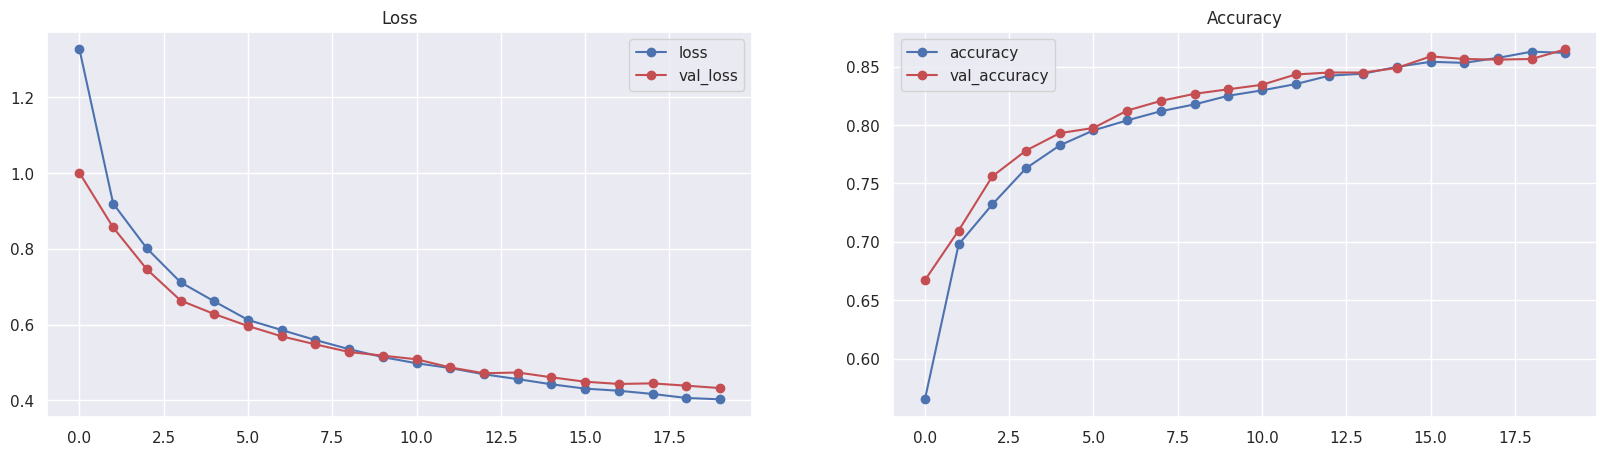

In [ ]:
featurenet_model_lab_daisy_canny_pca_25_2layer = performFeatureNet(X_lab_daisy_canny_train_pca_25, Y_train, X_lab_daisy_canny_val_pca_25, Y_val, num_layers=2)

Epoch 1/20
227/227 [==============================] - 3s 9ms/step - loss: 1.3494 - accuracy: 0.5589 - val_loss: 0.9709 - val_accuracy: 0.6821
Epoch 2/20
227/227 [==============================] - 3s 12ms/step - loss: 0.9235 - accuracy: 0.6943 - val_loss: 0.7924 - val_accuracy: 0.7439
Epoch 3/20
227/227 [==============================] - 3s 12ms/step - loss: 0.7809 - accuracy: 0.7416 - val_loss: 0.6964 - val_accuracy: 0.7704
Epoch 4/20
227/227 [==============================] - 2s 9ms/step - loss: 0.6956 - accuracy: 0.7705 - val_loss: 0.6544 - val_accuracy: 0.7792
Epoch 5/20
227/227 [==============================] - 2s 8ms/step - loss: 0.6429 - accuracy: 0.7908 - val_loss: 0.5813 - val_accuracy: 0.8096
Epoch 6/20
227/227 [==============================] - 2s 8ms/step - loss: 0.5991 - accuracy: 0.8013 - val_loss: 0.5699 - val_accuracy: 0.8135
Epoch 7/20
227/227 [==============================] - 2s 8ms/step - loss: 0.5781 - accuracy: 0.8103 - val_loss: 0.5431 - val_accuracy: 0.8085
Epoc

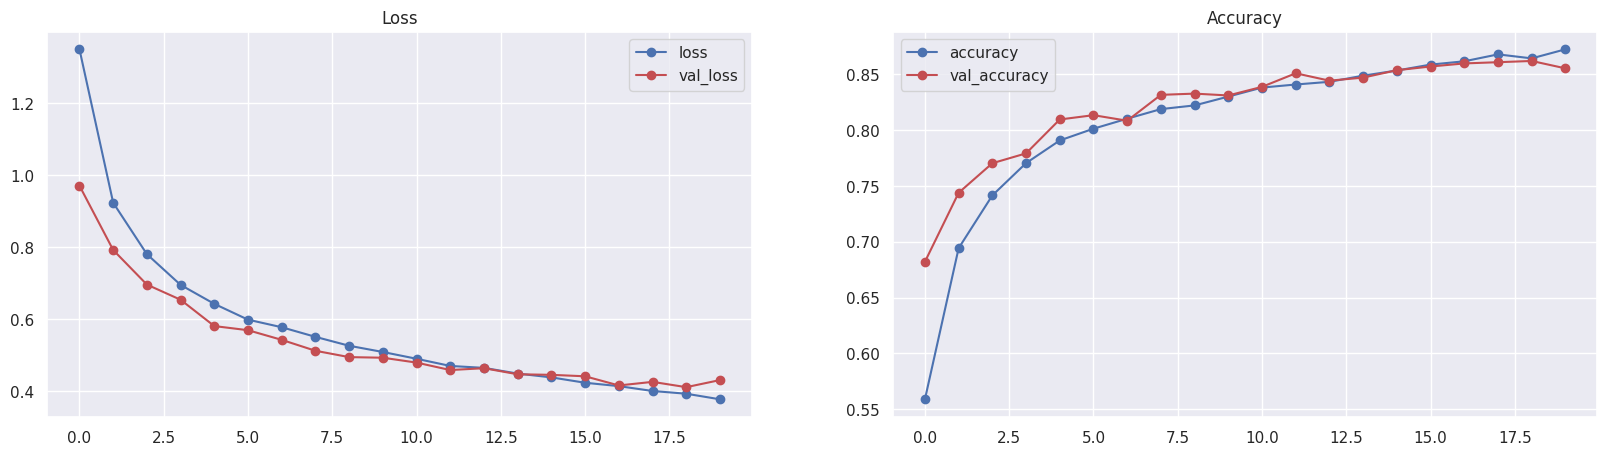

In [ ]:
featurenet_model_lab_daisy_canny_pca_25_3layer = performFeatureNet(X_lab_daisy_canny_train_pca_25, Y_train, X_lab_daisy_canny_val_pca_25, Y_val, num_layers=3)

In [35]:
randomforest_model_lab_daisy_canny_pca_25 = performRandomForest(X_lab_daisy_canny_train_pca_25, Y_train, X_lab_daisy_canny_val_pca_25, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8      11.594379           0.0         0.062705             0.0   
7       5.144780           0.0         0.030755             0.0   
6       2.560653           0.0         0.016116             0.0   
5      10.364871           0.0         0.056002             0.0   
4       4.546055           0.0         0.028167             0.0   

  param_max_depth param_n_estimators                                 params  \
8               7                200  {'max_depth': 7, 'n_estimators': 200}   
7               7                100  {'max_depth': 7, 'n_estimators': 100}   
6               7                 50   {'max_depth': 7, 'n_estimators': 50}   
5               6                200  {'max_depth': 6, 'n_estimators': 200}   
4               6                100  {'max_depth': 6, 'n_estimators': 100}   

   split0_test_score  mean_test_score  std_test_score  rank_test_score  
8           0.678256         0.678256             0.0                1  
7           0.674945         0.674945             0.0                2  
6           0.673841         0.673841             0.0                3  
5           0.656733         0.656733             0.0                4  
4           0.655077         0.655077             0.0                5





Train Accuracy: 70.70%
Validation Accuracy: 71.25%


#### Train + Validation Performance of 100 PCs of PCA for LAB B50 + Daisy S80 + Canny

In [16]:
lab_daisy_canny_pca_100, X_lab_daisy_canny_train_pca_100 = displayPca(X_lab_daisy_canny_train, display_pca = False)
X_lab_daisy_canny_val_pca_100 = lab_daisy_canny_pca_100.transform(X_lab_daisy_canny_val)

In [17]:
logistic_model_lab_daisy_canny_pca_100 = performLogisticRegression(X_lab_daisy_canny_train_pca_100, Y_train, X_lab_daisy_canny_val_pca_100, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5        9.780697           0.0         0.004058             0.0   
3        3.715516           0.0         0.002409             0.0   
11       8.310782           0.0         0.004762             0.0   
9        5.997544           0.0         0.002383             0.0   
1        2.693947           0.0         0.002661             0.0   

   param_class_weight param_max_iter param_penalty  \
5                None            500          None   
3                None            250          None   
11           balanced            500          None   
9            balanced            250          None   
1                None            100          None   

                                               params  split0_test_score  \
5   {'class_weight': None, 'max_iter': 500, 'penal...           0.838300   
3   {'class_weight': None, 'max_iter': 250, 'penal...           0.826711   
11  {'class_weight': 'balanced', 'max_iter': 500, ...           0.825607   
9   {'class_weight': 'balanced', 'max_iter': 250, ...           0.814018   
1   {'class_weight': None, 'max_iter': 100, 'penal...           0.794150   

    mean_test_score  std_test_score  rank_test_score  
5          0.838300             0.0                1  
3          0.826711             0.0                2  
11         0.825607             0.0                3  
9          0.814018             0.0                4  
1          0.794150             0.0                5





Train Accuracy: 85.08%
Validation Accuracy: 85.26%


Epoch 1/20
227/227 [==============================] - 3s 9ms/step - loss: 1.2122 - accuracy: 0.6050 - val_loss: 0.7448 - val_accuracy: 0.7572
Epoch 2/20
227/227 [==============================] - 2s 10ms/step - loss: 0.6732 - accuracy: 0.7784 - val_loss: 0.5780 - val_accuracy: 0.8068
Epoch 3/20
227/227 [==============================] - 2s 9ms/step - loss: 0.5589 - accuracy: 0.8171 - val_loss: 0.5140 - val_accuracy: 0.8317
Epoch 4/20
227/227 [==============================] - 2s 11ms/step - loss: 0.4890 - accuracy: 0.8344 - val_loss: 0.4678 - val_accuracy: 0.8433
Epoch 5/20
227/227 [==============================] - 3s 13ms/step - loss: 0.4409 - accuracy: 0.8497 - val_loss: 0.4200 - val_accuracy: 0.8576
Epoch 6/20
227/227 [==============================] - 2s 9ms/step - loss: 0.4007 - accuracy: 0.8670 - val_loss: 0.3978 - val_accuracy: 0.8687
Epoch 7/20
227/227 [==============================] - 2s 8ms/step - loss: 0.3712 - accuracy: 0.8745 - val_loss: 0.3659 - val_accuracy: 0.8791
Epo

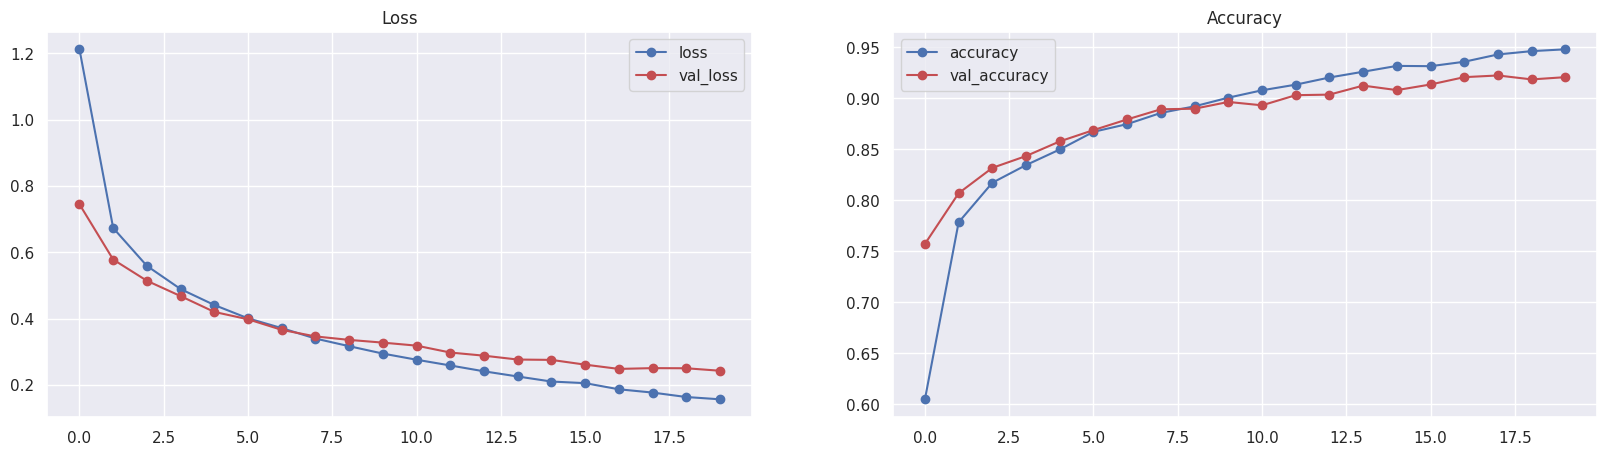

In [ ]:
featurenet_model_lab_daisy_canny_pca_100_2layer = performFeatureNet(X_lab_daisy_canny_train_pca_100, Y_train, X_lab_daisy_canny_val_pca_100, Y_val, num_layers=2)

Epoch 1/20
227/227 [==============================] - 4s 13ms/step - loss: 1.2522 - accuracy: 0.5873 - val_loss: 0.7285 - val_accuracy: 0.7616
Epoch 2/20
227/227 [==============================] - 3s 14ms/step - loss: 0.7112 - accuracy: 0.7651 - val_loss: 0.5589 - val_accuracy: 0.8118
Epoch 3/20
227/227 [==============================] - 2s 9ms/step - loss: 0.5636 - accuracy: 0.8149 - val_loss: 0.4660 - val_accuracy: 0.8499
Epoch 4/20
227/227 [==============================] - 2s 9ms/step - loss: 0.4843 - accuracy: 0.8402 - val_loss: 0.4179 - val_accuracy: 0.8620
Epoch 5/20
227/227 [==============================] - 2s 9ms/step - loss: 0.4263 - accuracy: 0.8595 - val_loss: 0.3669 - val_accuracy: 0.8797
Epoch 6/20
227/227 [==============================] - 2s 9ms/step - loss: 0.3800 - accuracy: 0.8726 - val_loss: 0.3397 - val_accuracy: 0.8891
Epoch 7/20
227/227 [==============================] - 2s 10ms/step - loss: 0.3411 - accuracy: 0.8874 - val_loss: 0.3341 - val_accuracy: 0.8913
Epo

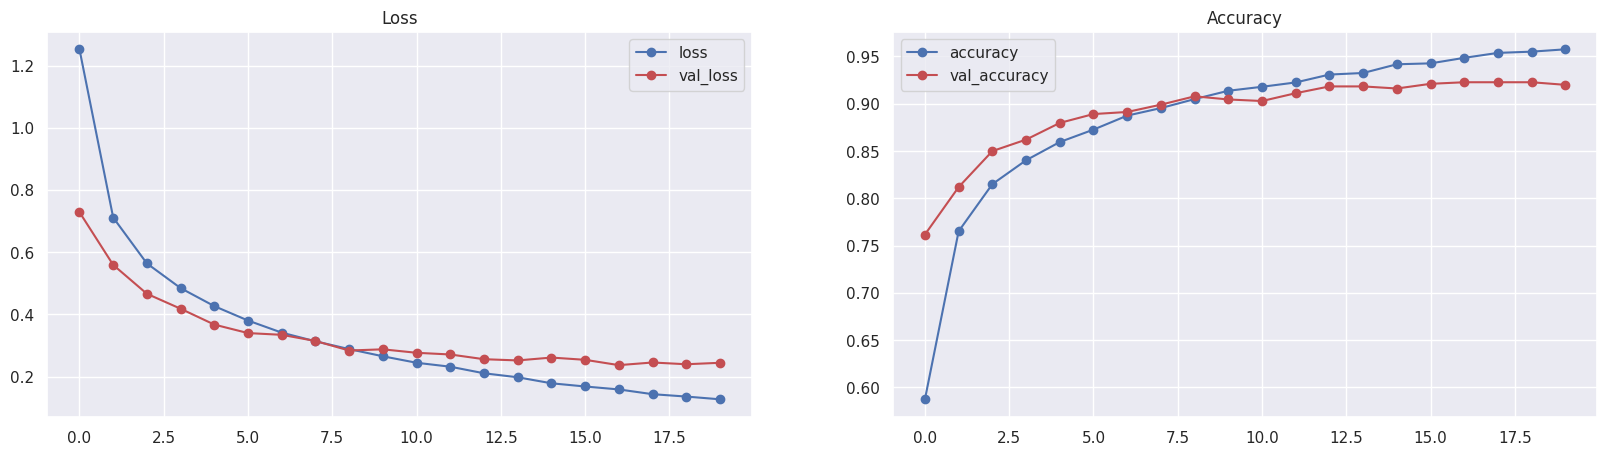

In [ ]:
featurenet_model_lab_daisy_canny_pca_100_3layer = performFeatureNet(X_lab_daisy_canny_train_pca_100, Y_train, X_lab_daisy_canny_val_pca_100, Y_val, num_layers=3)

In [38]:
randomforest_model_lab_daisy_canny_pca_100 = performRandomForest(X_lab_daisy_canny_train_pca_100, Y_train, X_lab_daisy_canny_val_pca_100, Y_val)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6       5.106656           0.0         0.017199             0.0   
8      22.442804           0.0         0.095973             0.0   
7      11.535949           0.0         0.032333             0.0   
4       8.823929           0.0         0.030639             0.0   
5      21.275985           0.0         0.058790             0.0   

  param_max_depth param_n_estimators                                 params  \
6               7                 50   {'max_depth': 7, 'n_estimators': 50}   
8               7                200  {'max_depth': 7, 'n_estimators': 200}   
7               7                100  {'max_depth': 7, 'n_estimators': 100}   
4               6                100  {'max_depth': 6, 'n_estimators': 100}   
5               6                200  {'max_depth': 6, 'n_estimators': 200}   

   split0_test_score  mean_test_score  std_test_score  rank_test_score  
6           0.650662         0.650662             0.0                1  
8           0.649007         0.649007             0.0                2  
7           0.643488         0.643488             0.0                3  
4           0.609823         0.609823             0.0                4  
5           0.599338         0.599338             0.0                5





Train Accuracy: 67.83%
Validation Accuracy: 67.38%


#### Comparing Performances

##### Performance Table for 25 PCs of PCA for LAB B50 + Daisy S80 + Canny

| Model | Training Accuracy | Validation Accuracy | Time Taken to Fit |
| --- | --- | --- | --- |
| Logistic Regression | 70.74% | 70.25% | 6.50 s |
| FeatureNet | 86.17% | 86.48% | 41.94 s |
| Random Forest | 70.70% | 71.25% | 11.59 s |

##### Performance Table for 100 PCs of PCA for LAB B50 + Daisy S80 + Canny

| Model | Training Accuracy | Validation Accuracy | Time Taken to Fit |
| --- | --- | --- | --- |
| Logistic Regression | 85.08% | 85.26% | 9.78 s |
| FeatureNet | 94.78% | 92.05% | 44.36 s |
| Random Forest | 67.83% | 67.38% | 5.11 s |

## Peformance of Test Data for Feature Vector of LAB B50 + Daisy S80 + Canny

In [18]:
def plotConfusionMatrix(predictions, labels):
  cm = confusion_matrix(labels, predictions)
  sns.heatmap(cm, annot=True, fmt="d", square=True)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

### Logistic Regression Results

In [19]:
start_time = time.time()
logistic_preds = logistic_model_lab_daisy_canny.predict(X_lab_daisy_canny_test)
print(f'Took {time.time() - start_time}s to gather predictions for test dataset')

print(f'Test Accuracy: {accuracy_score(logistic_preds, Y_test):.2%}\n')

Took 0.02911972999572754s to gather predictions for test dataset
Test Accuracy: 85.96%



In [20]:
print(classification_report(logistic_preds, Y_test))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       227
           1       0.48      0.59      0.53        82
           2       0.90      0.85      0.88       169
           3       0.81      0.79      0.80       197
           4       0.77      0.78      0.77        95
           5       0.83      0.85      0.84       173
           6       0.83      0.84      0.84       167
           7       0.84      0.83      0.84       143
           8       0.92      0.88      0.90        40
           9       0.95      0.96      0.96       531

    accuracy                           0.86      1824
   macro avg       0.82      0.82      0.82      1824
weighted avg       0.86      0.86      0.86      1824



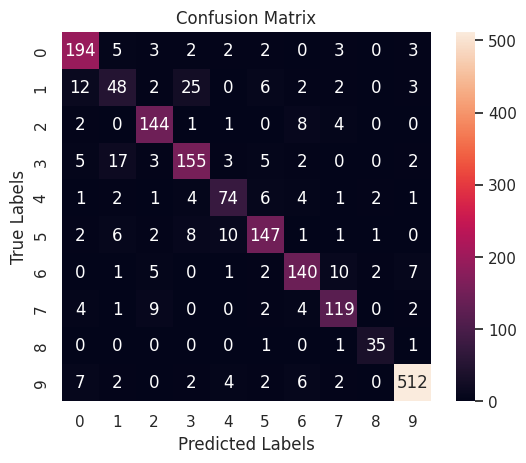

In [21]:
plotConfusionMatrix(logistic_preds, Y_test)

### FeatureNet Results

In [ ]:
start_time = time.time()
featurenet_pred_probas = featurenet_model_lab_daisy_canny_2layer.predict(X_lab_daisy_canny_test, verbose=0)
featurenet_preds = featurenet_pred_probas.argmax(axis=1)
print(f'Took {time.time() - start_time}s to gather predictions for test dataset')

print(f'Test Accuracy: {accuracy_score(featurenet_preds, Y_test):.2%}\n')

Took 0.8618683815002441s to gather predictions for test dataset
Test Accuracy: 88.98%



In [ ]:
print(classification_report(featurenet_preds, Y_test))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       240
           1       0.49      0.73      0.59        67
           2       0.94      0.88      0.91       170
           3       0.85      0.83      0.84       196
           4       0.78      0.89      0.83        84
           5       0.88      0.87      0.87       180
           6       0.89      0.87      0.88       173
           7       0.83      0.85      0.84       138
           8       0.89      0.94      0.92        36
           9       0.97      0.97      0.97       540

    accuracy                           0.89      1824
   macro avg       0.85      0.87      0.86      1824
weighted avg       0.90      0.89      0.89      1824



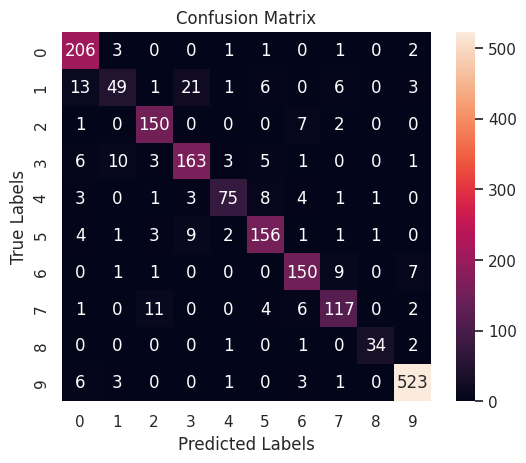

In [ ]:
plotConfusionMatrix(featurenet_preds, Y_test)

### Random Forest Results

In [40]:
start_time = time.time()
randomforest_preds = randomforest_model_lab_daisy_canny.predict(X_lab_daisy_canny_test)
print(f'Took {time.time() - start_time}s to gather predictions for test dataset')

print(f'Test Accuracy: {accuracy_score(randomforest_preds, Y_test):.2%}\n')

Took 0.07850980758666992s to gather predictions for test dataset
Test Accuracy: 76.15%



In [41]:
print(classification_report(randomforest_preds, Y_test))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       229
           1       0.14      0.82      0.24        17
           2       0.84      0.83      0.83       161
           3       0.74      0.74      0.74       194
           4       0.65      0.75      0.69        83
           5       0.66      0.83      0.73       141
           6       0.71      0.71      0.71       167
           7       0.57      0.76      0.66       106
           8       0.26      1.00      0.42        10
           9       0.98      0.73      0.84       716

    accuracy                           0.76      1824
   macro avg       0.64      0.80      0.67      1824
weighted avg       0.83      0.76      0.78      1824



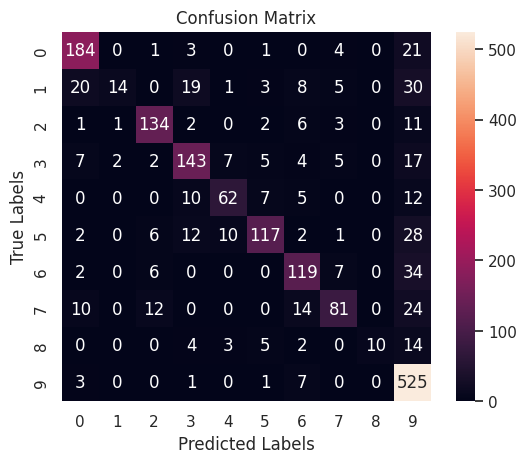

In [42]:
plotConfusionMatrix(randomforest_preds, Y_test)

## Peformance of Test Data for 100 PCs of PCA for Feature Vector of LAB B50 + Daisy S80 + Canny

In [22]:
X_lab_daisy_canny_test_pca_100 = lab_daisy_canny_pca_100.transform(X_lab_daisy_canny_test)

### Logistic Regression Results

In [23]:
start_time = time.time()
logistic_preds = logistic_model_lab_daisy_canny_pca_100.predict(X_lab_daisy_canny_test_pca_100)
print(f'Took {time.time() - start_time}s to gather predictions for test dataset')

print(f'Test Accuracy: {accuracy_score(logistic_preds, Y_test):.2%}\n')

Took 0.003019571304321289s to gather predictions for test dataset
Test Accuracy: 82.84%



In [24]:
print(classification_report(logistic_preds, Y_test))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       226
           1       0.47      0.55      0.51        85
           2       0.89      0.80      0.85       178
           3       0.74      0.75      0.75       190
           4       0.71      0.76      0.74        89
           5       0.74      0.81      0.78       162
           6       0.80      0.82      0.81       165
           7       0.79      0.79      0.79       141
           8       0.89      0.83      0.86        41
           9       0.95      0.93      0.94       547

    accuracy                           0.83      1824
   macro avg       0.79      0.79      0.79      1824
weighted avg       0.83      0.83      0.83      1824



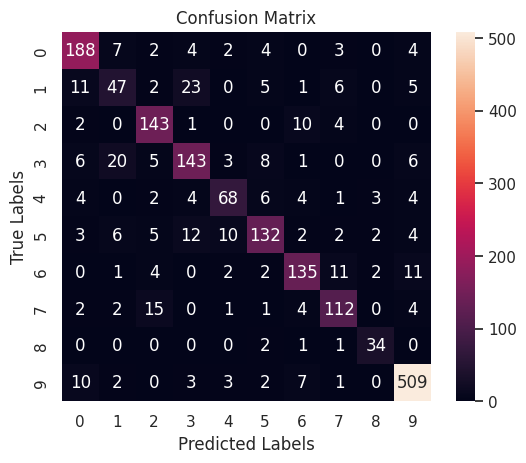

In [25]:
plotConfusionMatrix(logistic_preds, Y_test)

### FeatureNet Results

In [ ]:
start_time = time.time()
featurenet_pred_probas = featurenet_model_lab_daisy_canny_pca_100_2layer.predict(X_lab_daisy_canny_test_pca_100, verbose=0)
featurenet_preds = featurenet_pred_probas.argmax(axis=1)
print(f'Took {time.time() - start_time}s to gather predictions for test dataset')

print(f'Test Accuracy: {accuracy_score(featurenet_preds, Y_test):.2%}\n')

Took 0.5331943035125732s to gather predictions for test dataset
Test Accuracy: 91.12%



In [ ]:
print(classification_report(featurenet_preds, Y_test))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       222
           1       0.56      0.85      0.67        66
           2       0.96      0.91      0.93       169
           3       0.91      0.81      0.86       214
           4       0.86      0.86      0.86        96
           5       0.87      0.90      0.89       172
           6       0.93      0.88      0.90       177
           7       0.86      0.89      0.87       136
           8       0.89      0.92      0.91        37
           9       0.98      0.98      0.98       535

    accuracy                           0.91      1824
   macro avg       0.88      0.89      0.88      1824
weighted avg       0.92      0.91      0.91      1824



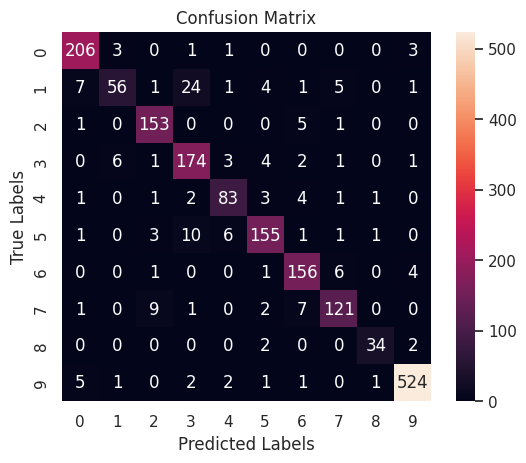

In [ ]:
plotConfusionMatrix(featurenet_preds, Y_test)

### Random Forest Results

In [44]:
start_time = time.time()
randomforest_preds = randomforest_model_lab_daisy_canny_pca_100.predict(X_lab_daisy_canny_test_pca_100)
print(f'Took {time.time() - start_time}s to gather predictions for test dataset')

print(f'Test Accuracy: {accuracy_score(randomforest_preds, Y_test):.2%}\n')

Took 0.023767709732055664s to gather predictions for test dataset
Test Accuracy: 65.30%



In [45]:
print(classification_report(randomforest_preds, Y_test))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75       193
           1       0.00      0.00      0.00         0
           2       0.88      0.78      0.83       180
           3       0.54      0.74      0.63       140
           4       0.59      0.74      0.66        77
           5       0.19      0.87      0.31        38
           6       0.63      0.82      0.71       129
           7       0.47      0.82      0.60        80
           8       0.00      0.00      0.00         0
           9       0.99      0.54      0.70       987

    accuracy                           0.65      1824
   macro avg       0.50      0.61      0.52      1824
weighted avg       0.83      0.65      0.70      1824



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


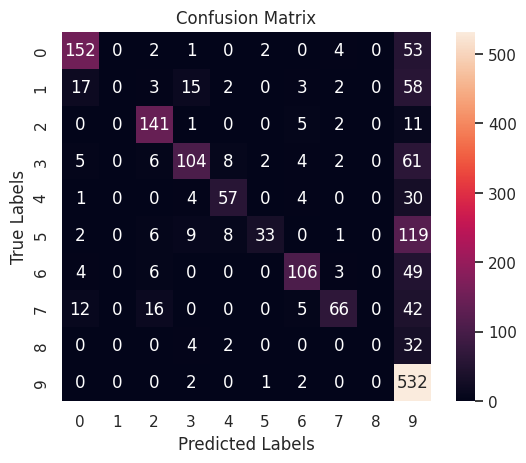

In [46]:
plotConfusionMatrix(randomforest_preds, Y_test)

## Complete Performance Table for LAB + Daisy + Canny

| Model | Training Accuracy | Validation Accuracy | Time Taken to Fit | Test Accuracy | Time Taken to Gather Test Predictions |
| --- | --- | --- | --- | --- | --- |
| Logistic Regression | 88.14% | 88.41% | 96.95 s | 85.96% | 0.029 s |
| FeatureNet | 89.52% | 89.79% | 78.76 s | 88.98% | 0.862 s |
| Random Forest | 78.37% | 77.54% | 63.77 s | 76.15% | 0.079 s |

## Complete Performance Table for 100 PCs of PCA for LAB + Daisy + Canny

| Model | Training Accuracy | Validation Accuracy | Time Taken to Fit | Test Accuracy | Time Taken to Gather Test Predictions |
| --- | --- | --- | --- | --- | --- |
| Logistic Regression | 85.08% | 85.26% | 9.78 s | 82.84% | 0.003 s |
| FeatureNet | 94.78% | 92.05% | 44.36 s | 91.12% | 0.533 s |
| Random Forest | 67.83% | 67.38% | 5.11 s | 65.30% | 0.024 s |